In [ ]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline 

import xgboost as xgb

from sklearn.model_selection import KFold

from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

pd.set_option('max_colwidth', 1000)
pd.set_option('max_rows',40)
pd.set_option('max_columns',1000)

import seaborn as sns 
sns.set_style('darkgrid')

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Loan prediction/train.csv")

test = pd.read_csv("/content/drive/MyDrive/Loan prediction/test.csv")

## TARGET 

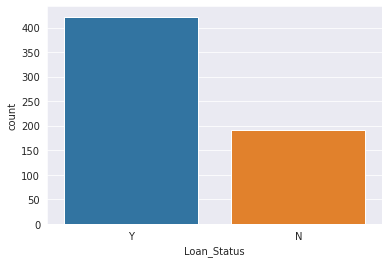

In [ ]:
sns.countplot(x="Loan_Status", data=data)

## Numeric Columns
## Categorical Columns

In [ ]:
num_cols = data.select_dtypes(exclude='object').copy()
cat_cols = data.select_dtypes(include='object').copy()
cat_cols = cat_cols.drop('Loan_ID',axis=1)

In [ ]:
num_cols.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
0,5849,0.0,NaN,360.0,1.0
1,4583,1508.0,128.0,360.0,1.0
2,3000,0.0,66.0,360.0,1.0
3,2583,2358.0,120.0,360.0,1.0
4,6000,0.0,141.0,360.0,1.0


In [ ]:
cat_cols.head()

,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,Urban,Y
1,Male,Yes,1,Graduate,No,Rural,N
2,Male,Yes,0,Graduate,Yes,Urban,Y
3,Male,Yes,0,Not Graduate,No,Urban,Y
4,Male,No,0,Graduate,No,Urban,Y


## Uni Variate Analaysis

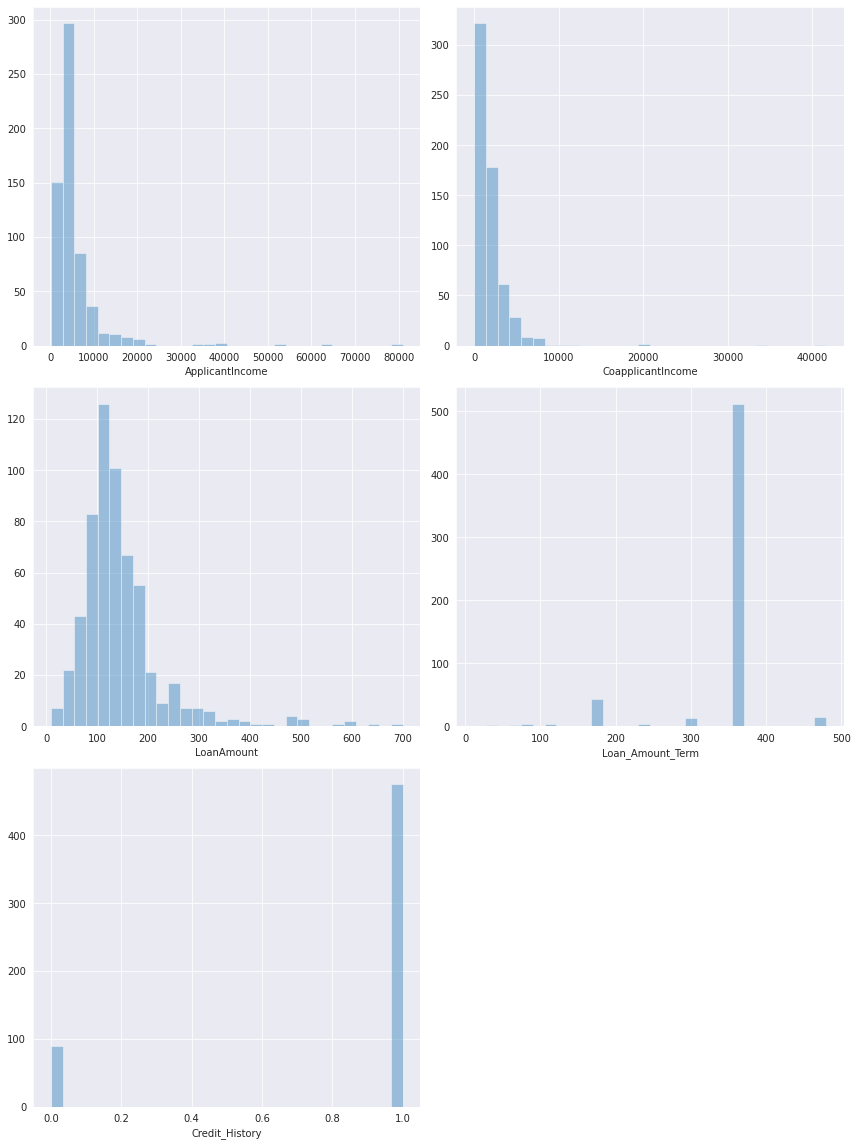

In [ ]:
fig = plt.figure(figsize=(12,16))
for index,col in enumerate(num_cols):
    plt.subplot(3,2,index+1)
    sns.distplot(num_cols.loc[:,col].dropna(),kde=False,bins=30)
fig.tight_layout(pad=1.0)

In [ ]:
data['Loan_Amount_Term'].value_counts()

360.0    512
180.0     44
480.0     15
300.0     13
84.0       4
240.0      4
120.0      3
36.0       2
60.0       2
12.0       1
Name: Loan_Amount_Term, dtype: int64

## Outliers

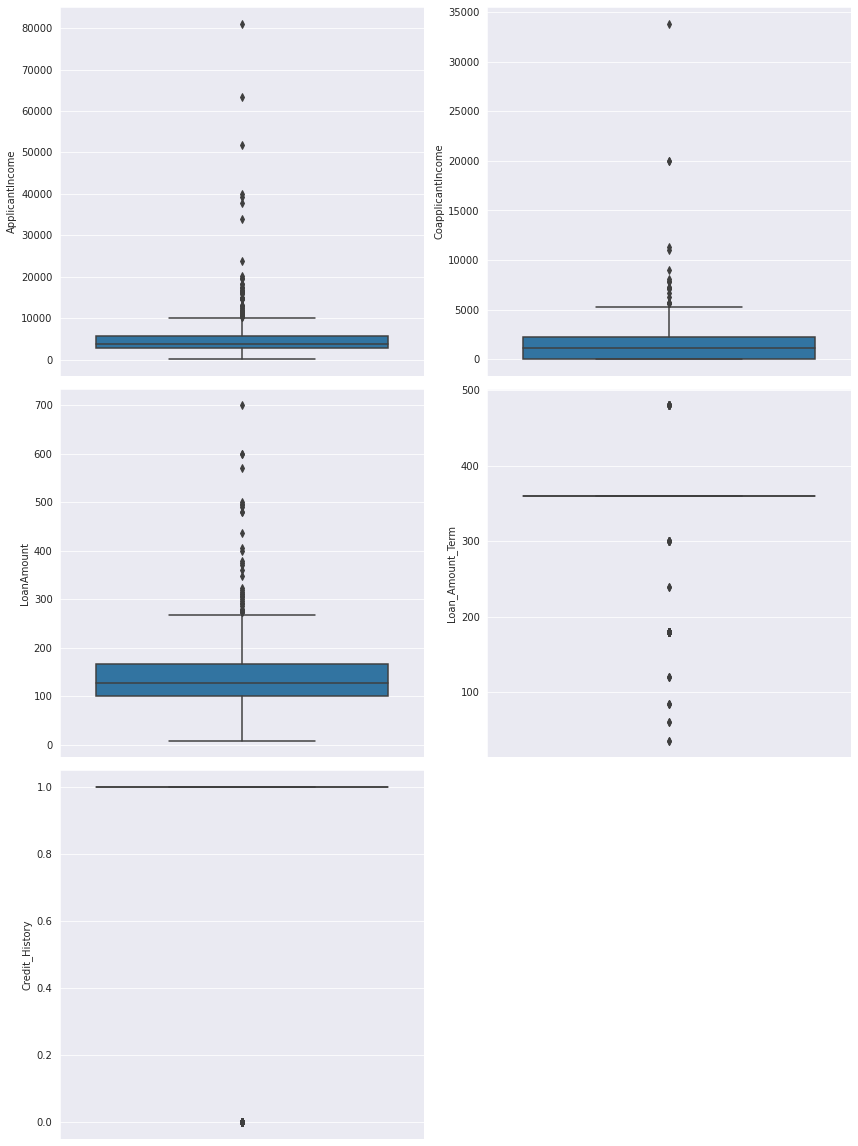

In [ ]:
fig = plt.figure(figsize=(12,16))
for index,col in enumerate(num_cols):
    plt.subplot(3,2,index+1)
    sns.boxplot(data=num_cols.dropna(), y=col)
fig.tight_layout(pad=1.0)

## Cat_Columns

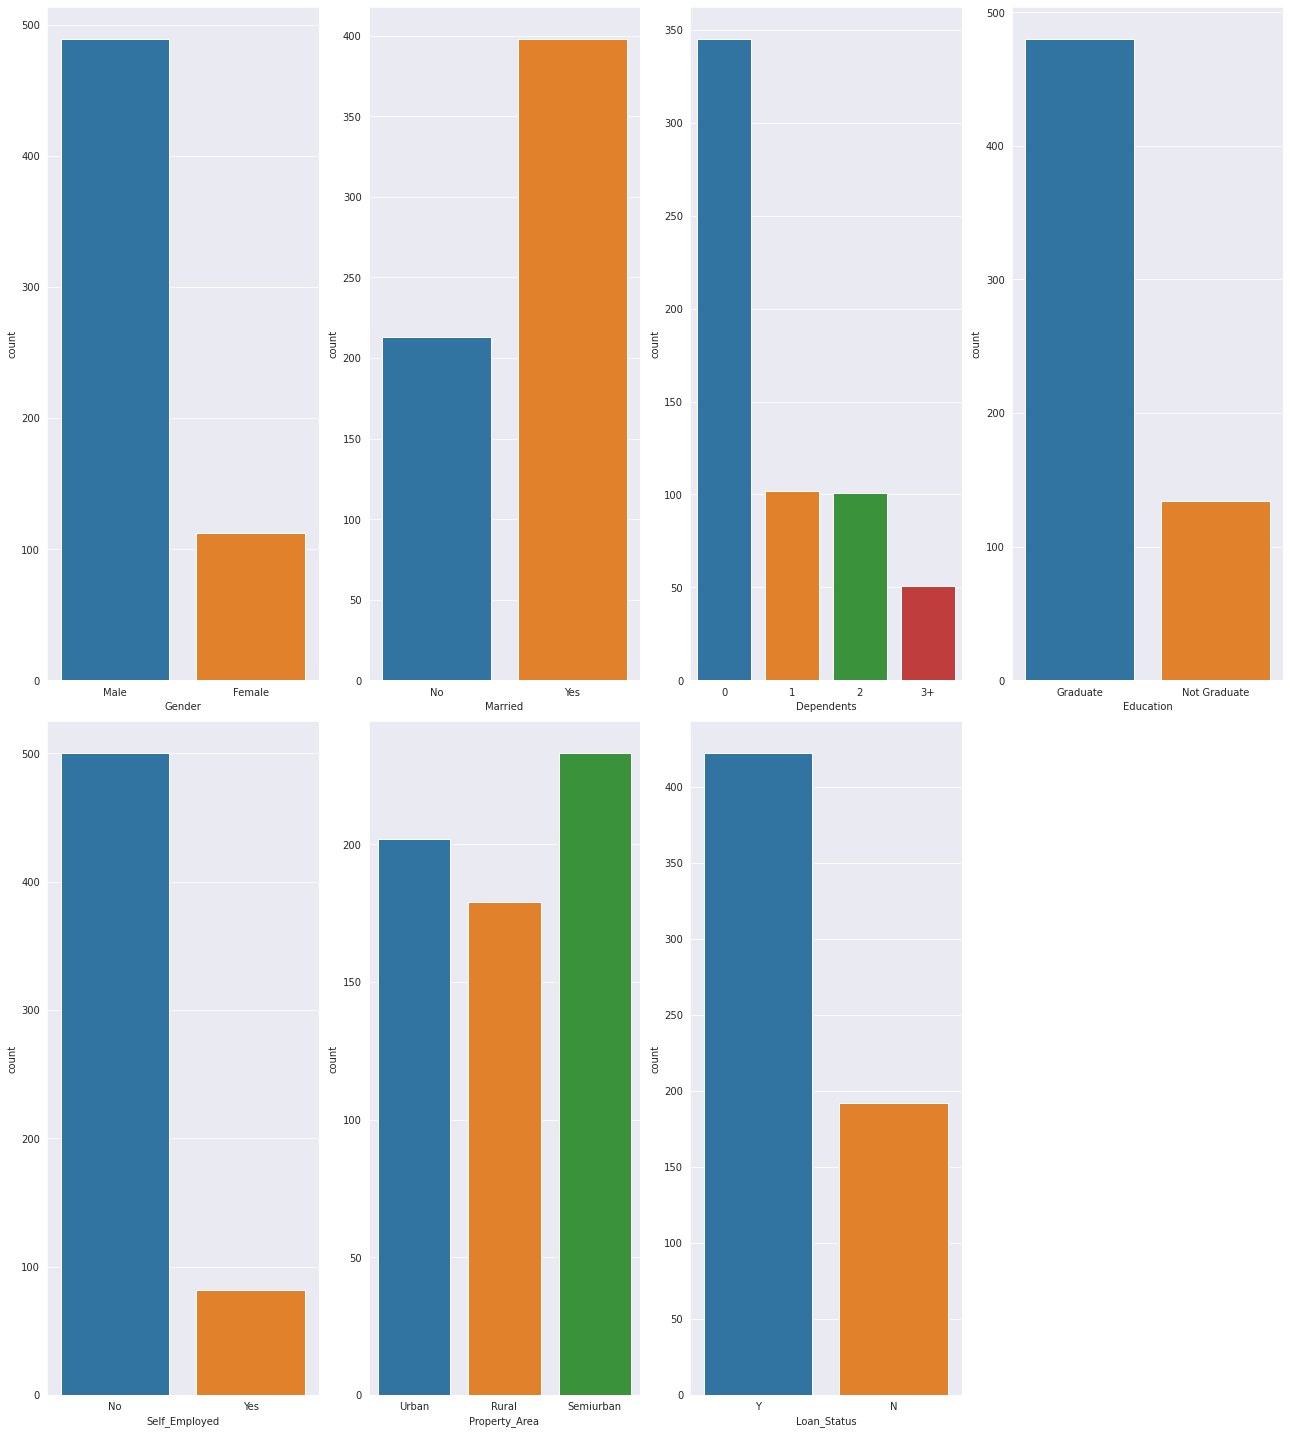

In [ ]:
fig = plt.figure(figsize=(18,20))
for index in range(len(cat_cols.columns)):
    plt.subplot(2,4,index+1)
    sns.countplot(x=cat_cols.iloc[:,index], data=cat_cols.dropna())
#    plt.xticks(rotation=90)
fig.tight_layout(pad=1.0)

## Missing Value





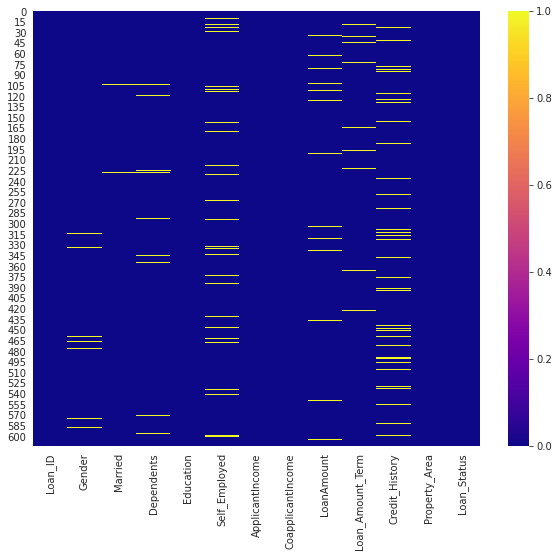

In [ ]:
# Checking Null values  
plt.figure(figsize=(10,8))
sns.heatmap(data.isnull(),cmap='plasma')

def percent_missing(d):
    percentage = pd.DataFrame(100*(d.isnull().sum()/len(d)),columns=['Missing_%']).sort_values('Missing_%',ascending=False)
    return (percentage.head(10))

In [ ]:
percent_missing(data)

,Missing_%
Credit_History,8.143322
Self_Employed,5.211726
LoanAmount,3.583062
Dependents,2.442997
Loan_Amount_Term,2.280130
Gender,2.117264
Married,0.488599
Loan_ID,0.000000
Education,0.000000
ApplicantIncome,0.000000


In [ ]:
#Mapp the Y/N to 1/0
mapp = {'Y':1,'N':0}
data["Loan_Status"] = data["Loan_Status"].map(mapp)

## Correlations

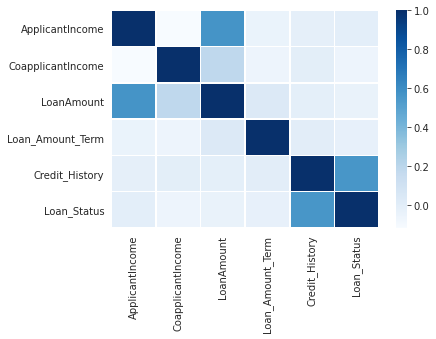

In [ ]:
corr = data.corr()
sns.heatmap(data=corr.dropna(),cmap='Blues',linewidth=0.5)

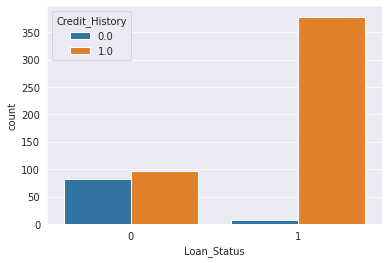

In [ ]:
sns.countplot(x='Loan_Status',data=data,hue='Credit_History')

In [ ]:
corr["Loan_Status"]

ApplicantIncome     -0.004710
CoapplicantIncome   -0.059187
LoanAmount          -0.037318
Loan_Amount_Term    -0.021268
Credit_History       0.561678
Loan_Status          1.000000
Name: Loan_Status, dtype: float64

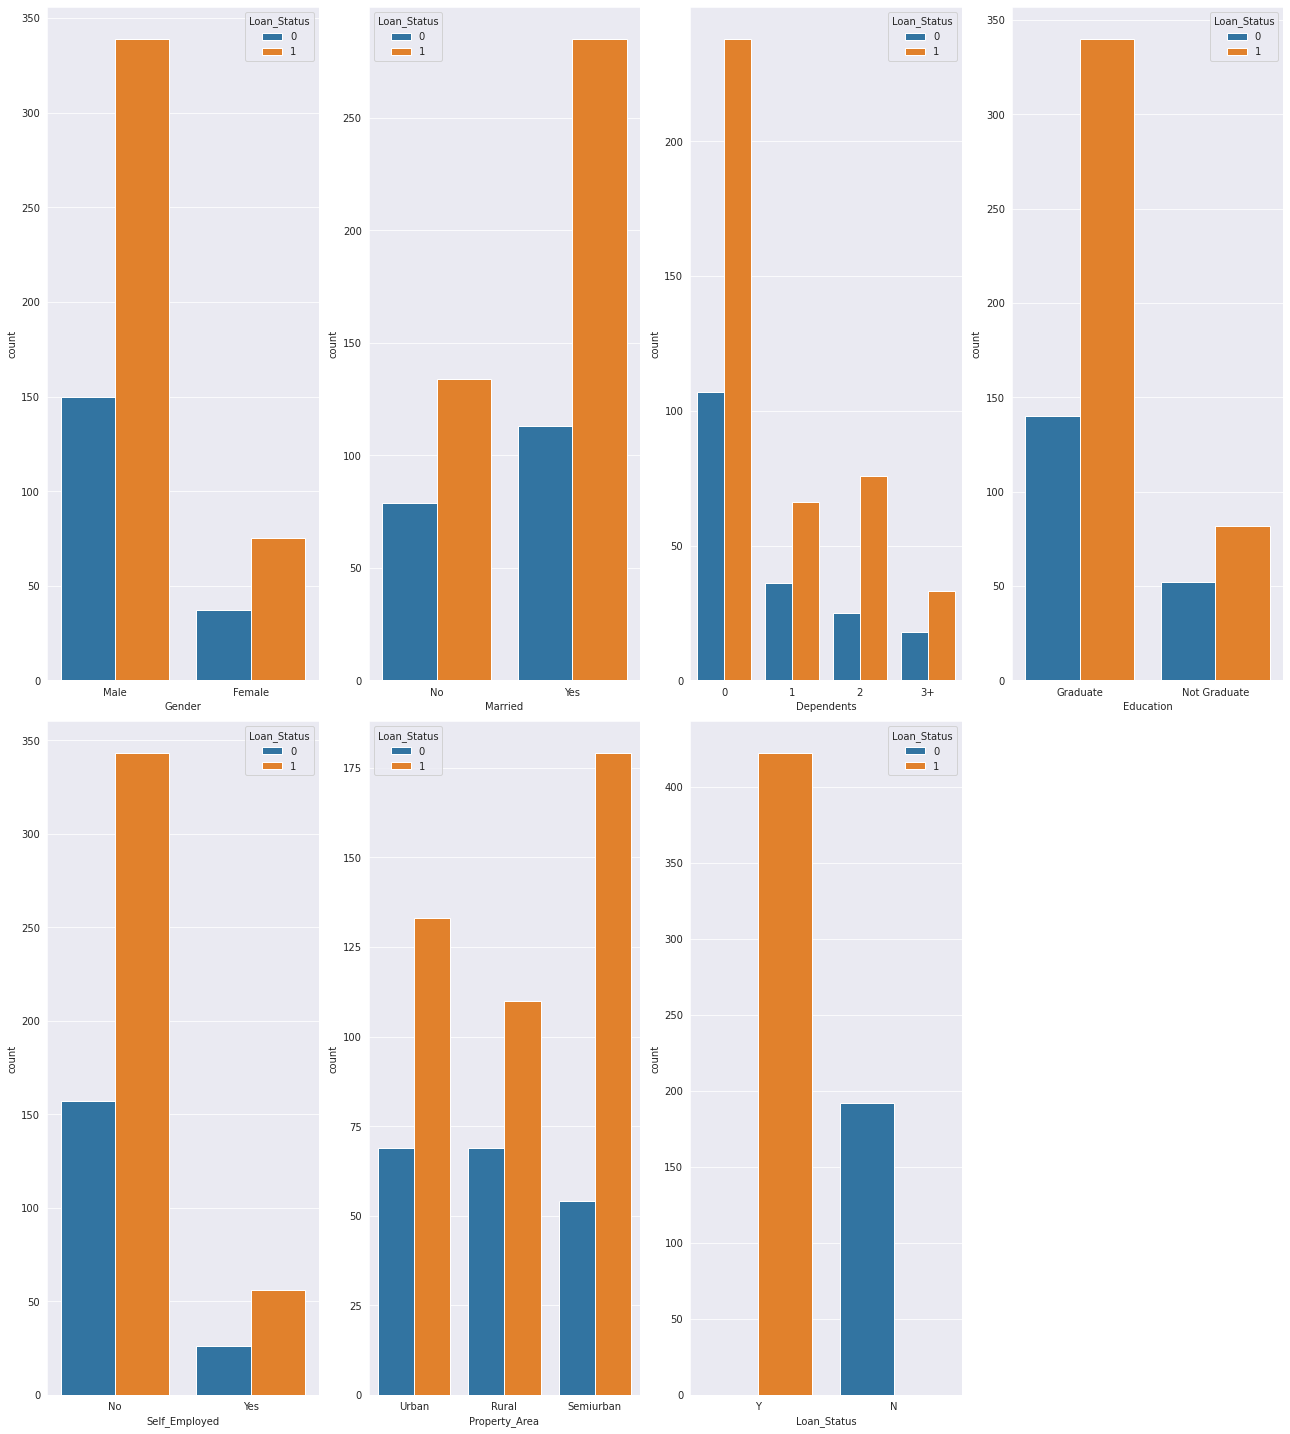

In [ ]:
fig = plt.figure(figsize=(18,20))
for index in range(len(cat_cols.columns)):
    plt.subplot(2,4,index+1)
    sns.countplot(x=cat_cols.iloc[:,index], data=cat_cols.dropna(),hue=data['Loan_Status'])
#    plt.xticks(rotation=90)
fig.tight_layout(pad=1.0)

## Data Processing
## Outliers

In [ ]:
data = data[data['ApplicantIncome'] < 50000]
data = data[data['LoanAmount'] < 500]

## Mapping

In [ ]:
mapp_gender = {'Male':0,'Female':1}
mapp_married = {'No':0,'Yes':1}
mapp_dep = {'0':0,'1':1,'2':1,'3+':1}
mapp_edu = {'Not Graduate':0,'Graduate':1}
mapp_se = {'No':0,'Yes':1}
mapp_pa = {'Semiurban':1,'Urban':2,'Rural':3}


data['Gender'] = data['Gender'].map(mapp_gender)
data['Married'] = data['Married'].map(mapp_married)
data['Dependents'] = data['Dependents'].map(mapp_dep)
data['Education'] = data['Education'].map(mapp_edu)
data['Self_Employed'] = data['Self_Employed'].map(mapp_se)
data['Property_Area'] = data['Property_Area'].map(mapp_pa)


test['Gender'] = test['Gender'].map(mapp_gender)
test['Married'] = test['Married'].map(mapp_married)
test['Dependents'] = test['Dependents'].map(mapp_dep)
test['Education'] = test['Education'].map(mapp_edu)
test['Self_Employed'] = test['Self_Employed'].map(mapp_se)
test['Property_Area'] = test['Property_Area'].map(mapp_pa)

mapp_lt = {360.0 :1,180.0 : 0,480.0:0,300.0:0,84.0: 0,240.0: 0,120.0: 0,36.0: 0,60.0: 0,12.0:0}
data['Loan_Amount_Term'] = data['Loan_Amount_Term'].map(mapp_lt)
test['Loan_Amount_Term'] = test['Loan_Amount_Term'].map(mapp_lt)

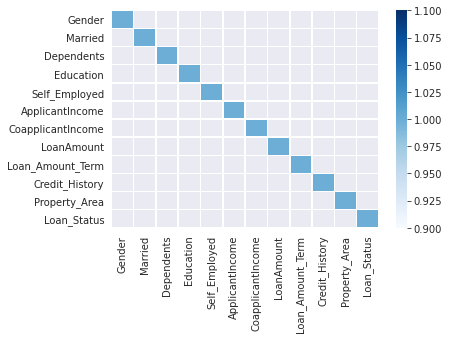

In [ ]:
corr = data.corr()
sns.heatmap(data=corr.dropna(),mask = corr < 0.8,cmap='Blues',linewidth=0.5)

## Filling Missing Values 

In [ ]:
loan_amt_avg = test.groupby('ApplicantIncome').mean()['LoanAmount']
def fill_loan_amt(LoanAmount,ApplicantIncome):
    if np.isnan(LoanAmount):
        return loan_amt_avg[ApplicantIncome]
    else:
        return LoanAmount
test['LoanAmount'] = test.apply(lambda x: fill_loan_amt(x['LoanAmount'], x['ApplicantIncome']), axis=1)
test['LoanAmount'] = test['LoanAmount'].fillna(136.9586777)

In [ ]:
loan_amt_avg = data.groupby('ApplicantIncome').mean()['LoanAmount']

def fill_loan_amt(LoanAmount,ApplicantIncome):
    if np.isnan(LoanAmount):
        return loan_amt_avg[ApplicantIncome]
    else:
        return LoanAmount
data['LoanAmount'] = data.apply(lambda x: fill_loan_amt(x['LoanAmount'], x['ApplicantIncome']), axis=1)
data['LoanAmount'] = data['LoanAmount'].fillna(146.4121622)

In [ ]:
test['Dependents'] = test['Dependents'].fillna(1)
data['Dependents'] = data['Dependents'].fillna(1)


In [ ]:
def fill_gender(Gender,Married):
    if np.isnan(Gender):
        if Married ==1:
            return (1)
        else:
            return (0)
    else:
        return Gender
test['Gender'] = test.apply(lambda x: fill_gender(x['Gender'], x['Married']), axis=1)
data['Gender'] = data.apply(lambda x: fill_gender(x['Gender'], x['Married']), axis=1)

In [ ]:
def fill_self_emp(Self_Employed,ApplicantIncome):
    if np.isnan(Self_Employed):
        if ApplicantIncome >=7380:
            return (1)
        else:
            return (0)
    else:
        return Self_Employed
test['Self_Employed'] = test.apply(lambda x: fill_self_emp(x['Self_Employed'], x['ApplicantIncome']), axis=1)
data['Self_Employed'] = data.apply(lambda x: fill_self_emp(x['Self_Employed'], x['ApplicantIncome']), axis=1)

In [ ]:
test['Loan_Amount_Term'] = test['Loan_Amount_Term'].fillna(0)
data['Loan_Amount_Term'] = data['Loan_Amount_Term'].fillna(0)


In [ ]:
test['Credit_History'] = test['Credit_History'].fillna(-999)
data = data.dropna()

In [ ]:
def fill_CoapplicantIncome(CoapplicantIncome):
    if CoapplicantIncome ==0:
         return (1)
    else:
        return (0)
data['CoapplicantIncome'] = data.apply(lambda x: fill_CoapplicantIncome(x['CoapplicantIncome']), axis=1)
test['CoapplicantIncome'] = test.apply(lambda x: fill_CoapplicantIncome(x['CoapplicantIncome']), axis=1)

In [ ]:
mapp = {1:'Y',0:'N'}
data["Loan_Status"] = data["Loan_Status"].map(mapp)

X_train = data.drop(['Loan_ID','Loan_Status'],axis=1)
y_train = data['Loan_Status']

## Tuning

In [ ]:
!pip install optuna

     |████████████████████████████████| 307kB 22.9MB/s 
     |████████████████████████████████| 174kB 30.8MB/s 
     |████████████████████████████████| 81kB 8.3MB/s 
     |████████████████████████████████| 81kB 9.6MB/s 
     |████████████████████████████████| 112kB 43.9MB/s 
     |████████████████████████████████| 143kB 27.1MB/s 
     |████████████████████████████████| 51kB 5.8MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-cp37-none-any.whl size=11136 sha256=ab0b1c69d042fd6f2bc9afb1a953e702724910974e19928afd7e523bbfdb0ef9
  Stored in directory: /root/.cache/pip/wheels/25/af/b8/3407109267803f4015e1ee2ff23be0c8c19ce4008665931ee1
Successfully built pyperclip


In [ ]:
import optuna

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 350, 1000),
        'max_depth': trial.suggest_int('max_depth', 6, 13),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.009, 0.10),
        'subsample': trial.suggest_uniform('subsample', 0.50, 1),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.50, 1),
        'gamma': trial.suggest_int('gamma', 0, 0.05),
        'missing': -999,
        #'scale_pos_weight': 0.48,
       }

    clf = xgb.XGBClassifier(**params)
    auccuracies = []
    X_train_k = X_train.values
    y_train_k = y_train.values
    kf = KFold(n_splits=3,random_state=2000,shuffle=True)
    for train_idx, valid_idx in kf.split(X_train_k,y_train_k):
#          X_train_k, X_test = X_train[train_index], X_train[test_index]
#          y_train_k, y_test = y_train[train_index], y_train[test_index]
            train_data = X_train_k[train_idx, :], y_train_k[train_idx]
            valid_data = X_train_k[valid_idx, :], y_train_k[valid_idx]
        
            clf.fit(X_train_k[train_idx, :], y_train_k[train_idx])
            pred = clf.predict(X_train_k[valid_idx, :])
            accuracy = accuracy_score(y_train_k[valid_idx],pred)
            auccuracies.append(accuracy)
    print(f'Trial done: Accuracy values on folds: {auccuracies}')
    return np.average(auccuracies)

In [ ]:
n_trials = 500

FIT_XGB = True

if FIT_XGB:
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2021-07-03 07:04:34,565] A new study created in memory with name: no-name-42efb87f-c3c9-4dfc-b7dc-24eb19c79f2f
[I 2021-07-03 07:04:35,473] Trial 0 finished with value: 0.7659176029962547 and parameters: {'n_estimators': 958, 'max_depth': 7, 'learning_rate': 0.08402730529703267, 'subsample': 0.8150341101410407, 'colsample_bytree': 0.5719658492141805, 'gamma': 0}. Best is trial 0 with value: 0.7659176029962547.


Trial done: Accuracy values on folds: [0.7359550561797753, 0.7584269662921348, 0.8033707865168539]


[I 2021-07-03 07:04:36,398] Trial 1 finished with value: 0.7808988764044944 and parameters: {'n_estimators': 802, 'max_depth': 6, 'learning_rate': 0.06930200203500059, 'subsample': 0.6213685280276664, 'colsample_bytree': 0.8290872974939005, 'gamma': 0}. Best is trial 1 with value: 0.7808988764044944.


Trial done: Accuracy values on folds: [0.7696629213483146, 0.7696629213483146, 0.8033707865168539]


[I 2021-07-03 07:04:37,651] Trial 2 finished with value: 0.7790262172284644 and parameters: {'n_estimators': 827, 'max_depth': 11, 'learning_rate': 0.03607498014773273, 'subsample': 0.8654011450091491, 'colsample_bytree': 0.9098643711223793, 'gamma': 0}. Best is trial 1 with value: 0.7808988764044944.


Trial done: Accuracy values on folds: [0.7640449438202247, 0.7640449438202247, 0.8089887640449438]


[I 2021-07-03 07:04:38,346] Trial 3 finished with value: 0.7790262172284644 and parameters: {'n_estimators': 505, 'max_depth': 8, 'learning_rate': 0.052402194793899945, 'subsample': 0.8701092457311055, 'colsample_bytree': 0.8097424071685041, 'gamma': 0}. Best is trial 1 with value: 0.7808988764044944.


Trial done: Accuracy values on folds: [0.7528089887640449, 0.7584269662921348, 0.8258426966292135]


[I 2021-07-03 07:04:39,538] Trial 4 finished with value: 0.7734082397003745 and parameters: {'n_estimators': 770, 'max_depth': 8, 'learning_rate': 0.030115330022518497, 'subsample': 0.98870650869103, 'colsample_bytree': 0.9475200037852292, 'gamma': 0}. Best is trial 1 with value: 0.7808988764044944.


Trial done: Accuracy values on folds: [0.7696629213483146, 0.7528089887640449, 0.797752808988764]


[I 2021-07-03 07:04:40,721] Trial 5 finished with value: 0.7752808988764045 and parameters: {'n_estimators': 906, 'max_depth': 11, 'learning_rate': 0.05902973965473082, 'subsample': 0.8188630491579809, 'colsample_bytree': 0.9360155687418327, 'gamma': 0}. Best is trial 1 with value: 0.7808988764044944.


Trial done: Accuracy values on folds: [0.7696629213483146, 0.7471910112359551, 0.8089887640449438]


[I 2021-07-03 07:04:41,300] Trial 6 finished with value: 0.7677902621722846 and parameters: {'n_estimators': 470, 'max_depth': 6, 'learning_rate': 0.08577255964560954, 'subsample': 0.9675740095613843, 'colsample_bytree': 0.9592348965372011, 'gamma': 0}. Best is trial 1 with value: 0.7808988764044944.


Trial done: Accuracy values on folds: [0.7696629213483146, 0.7415730337078652, 0.7921348314606742]


[I 2021-07-03 07:04:42,298] Trial 7 finished with value: 0.7846441947565542 and parameters: {'n_estimators': 778, 'max_depth': 11, 'learning_rate': 0.028300039244292613, 'subsample': 0.6986232112936499, 'colsample_bytree': 0.6928686280073126, 'gamma': 0}. Best is trial 7 with value: 0.7846441947565542.


Trial done: Accuracy values on folds: [0.7528089887640449, 0.7752808988764045, 0.8258426966292135]


[I 2021-07-03 07:04:42,964] Trial 8 finished with value: 0.801498127340824 and parameters: {'n_estimators': 485, 'max_depth': 10, 'learning_rate': 0.015283726496251138, 'subsample': 0.7283991193103153, 'colsample_bytree': 0.5975683339829652, 'gamma': 0}. Best is trial 8 with value: 0.801498127340824.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.7808988764044944, 0.8370786516853933]


[I 2021-07-03 07:04:44,081] Trial 9 finished with value: 0.7846441947565542 and parameters: {'n_estimators': 776, 'max_depth': 11, 'learning_rate': 0.02074689504049611, 'subsample': 0.9999060415901035, 'colsample_bytree': 0.6756059580465223, 'gamma': 0}. Best is trial 8 with value: 0.801498127340824.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.7584269662921348, 0.8033707865168539]


[I 2021-07-03 07:04:44,731] Trial 10 finished with value: 0.801498127340824 and parameters: {'n_estimators': 593, 'max_depth': 13, 'learning_rate': 0.012808416639597696, 'subsample': 0.541175627927225, 'colsample_bytree': 0.5260701906229672, 'gamma': 0}. Best is trial 8 with value: 0.801498127340824.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.797752808988764, 0.8202247191011236]


[I 2021-07-03 07:04:45,379] Trial 11 finished with value: 0.8052434456928839 and parameters: {'n_estimators': 586, 'max_depth': 13, 'learning_rate': 0.011135157537413334, 'subsample': 0.5411767983652823, 'colsample_bytree': 0.504340213322897, 'gamma': 0}. Best is trial 11 with value: 0.8052434456928839.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.797752808988764, 0.8370786516853933]


[I 2021-07-03 07:04:46,130] Trial 12 finished with value: 0.8108614232209738 and parameters: {'n_estimators': 630, 'max_depth': 13, 'learning_rate': 0.00955474996147236, 'subsample': 0.5053999235849913, 'colsample_bytree': 0.5897232640351506, 'gamma': 0}. Best is trial 12 with value: 0.8108614232209738.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.8370786516853933]


[I 2021-07-03 07:04:46,805] Trial 13 finished with value: 0.8071161048689138 and parameters: {'n_estimators': 627, 'max_depth': 13, 'learning_rate': 0.01077848969460148, 'subsample': 0.5010720300332144, 'colsample_bytree': 0.5095257176407606, 'gamma': 0}. Best is trial 12 with value: 0.8108614232209738.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8033707865168539, 0.8314606741573034]


[I 2021-07-03 07:04:47,244] Trial 14 finished with value: 0.7883895131086142 and parameters: {'n_estimators': 370, 'max_depth': 13, 'learning_rate': 0.045556134022790115, 'subsample': 0.5138573415095884, 'colsample_bytree': 0.6228633653490196, 'gamma': 0}. Best is trial 12 with value: 0.8108614232209738.


Trial done: Accuracy values on folds: [0.7528089887640449, 0.7808988764044944, 0.8314606741573034]


[I 2021-07-03 07:04:48,007] Trial 15 finished with value: 0.8052434456928839 and parameters: {'n_estimators': 653, 'max_depth': 12, 'learning_rate': 0.009386630415805067, 'subsample': 0.6116453332909784, 'colsample_bytree': 0.5050294335060229, 'gamma': 0}. Best is trial 12 with value: 0.8108614232209738.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8033707865168539, 0.8202247191011236]


[I 2021-07-03 07:04:48,835] Trial 16 finished with value: 0.7865168539325843 and parameters: {'n_estimators': 678, 'max_depth': 12, 'learning_rate': 0.038649907588133345, 'subsample': 0.592533252171192, 'colsample_bytree': 0.6723241740679539, 'gamma': 0}. Best is trial 12 with value: 0.8108614232209738.


Trial done: Accuracy values on folds: [0.7584269662921348, 0.7808988764044944, 0.8202247191011236]


[I 2021-07-03 07:04:49,661] Trial 17 finished with value: 0.7827715355805244 and parameters: {'n_estimators': 668, 'max_depth': 12, 'learning_rate': 0.02465591623313832, 'subsample': 0.6744480244452017, 'colsample_bytree': 0.5591242609295258, 'gamma': 0}. Best is trial 12 with value: 0.8108614232209738.


Trial done: Accuracy values on folds: [0.7696629213483146, 0.7528089887640449, 0.8258426966292135]


[I 2021-07-03 07:04:50,110] Trial 18 finished with value: 0.7808988764044944 and parameters: {'n_estimators': 353, 'max_depth': 9, 'learning_rate': 0.0708802267324327, 'subsample': 0.5073911045449979, 'colsample_bytree': 0.7371165862622856, 'gamma': 0}. Best is trial 12 with value: 0.8108614232209738.


Trial done: Accuracy values on folds: [0.7584269662921348, 0.7696629213483146, 0.8146067415730337]


[I 2021-07-03 07:04:50,802] Trial 19 finished with value: 0.797752808988764 and parameters: {'n_estimators': 566, 'max_depth': 13, 'learning_rate': 0.01904083885489573, 'subsample': 0.5754850739299684, 'colsample_bytree': 0.6173844706232506, 'gamma': 0}. Best is trial 12 with value: 0.8108614232209738.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.7696629213483146, 0.8426966292134831]


[I 2021-07-03 07:04:51,448] Trial 20 finished with value: 0.7659176029962547 and parameters: {'n_estimators': 700, 'max_depth': 10, 'learning_rate': 0.09832437729687848, 'subsample': 0.6662211876004578, 'colsample_bytree': 0.5401922704249713, 'gamma': 0}. Best is trial 12 with value: 0.8108614232209738.


Trial done: Accuracy values on folds: [0.7191011235955056, 0.7584269662921348, 0.8202247191011236]


[I 2021-07-03 07:04:52,230] Trial 21 finished with value: 0.803370786516854 and parameters: {'n_estimators': 679, 'max_depth': 12, 'learning_rate': 0.010562712874162473, 'subsample': 0.6009446307717538, 'colsample_bytree': 0.5004212036441626, 'gamma': 0}. Best is trial 12 with value: 0.8108614232209738.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.797752808988764, 0.8258426966292135]


[I 2021-07-03 07:04:52,891] Trial 22 finished with value: 0.8071161048689138 and parameters: {'n_estimators': 608, 'max_depth': 12, 'learning_rate': 0.01124417624791095, 'subsample': 0.5107565825454968, 'colsample_bytree': 0.5058208087030165, 'gamma': 0}. Best is trial 12 with value: 0.8108614232209738.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8033707865168539, 0.8370786516853933]


[I 2021-07-03 07:04:53,546] Trial 23 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 553, 'max_depth': 13, 'learning_rate': 0.009452298547803453, 'subsample': 0.510881400777612, 'colsample_bytree': 0.5819173858944716, 'gamma': 0}. Best is trial 23 with value: 0.8127340823970037.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.8426966292134831]


[I 2021-07-03 07:04:54,089] Trial 24 finished with value: 0.803370786516854 and parameters: {'n_estimators': 433, 'max_depth': 13, 'learning_rate': 0.02185913978236233, 'subsample': 0.5566779896124394, 'colsample_bytree': 0.6316629586112115, 'gamma': 0}. Best is trial 23 with value: 0.8127340823970037.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.7921348314606742, 0.8370786516853933]


[I 2021-07-03 07:04:54,688] Trial 25 finished with value: 0.7883895131086143 and parameters: {'n_estimators': 531, 'max_depth': 12, 'learning_rate': 0.03553077913971558, 'subsample': 0.5097102275532739, 'colsample_bytree': 0.5760464167987511, 'gamma': 0}. Best is trial 23 with value: 0.8127340823970037.


Trial done: Accuracy values on folds: [0.7528089887640449, 0.7865168539325843, 0.8258426966292135]


[I 2021-07-03 07:04:55,245] Trial 26 finished with value: 0.8033707865168539 and parameters: {'n_estimators': 439, 'max_depth': 12, 'learning_rate': 0.017077081560121055, 'subsample': 0.5027817252461564, 'colsample_bytree': 0.7256460713232409, 'gamma': 0}. Best is trial 23 with value: 0.8127340823970037.


Trial done: Accuracy values on folds: [0.7752808988764045, 0.8033707865168539, 0.8314606741573034]


[I 2021-07-03 07:04:56,232] Trial 27 finished with value: 0.7883895131086143 and parameters: {'n_estimators': 736, 'max_depth': 13, 'learning_rate': 0.027788738741349475, 'subsample': 0.6439968148855002, 'colsample_bytree': 0.7878360125040726, 'gamma': 0}. Best is trial 23 with value: 0.8127340823970037.


Trial done: Accuracy values on folds: [0.7696629213483146, 0.7696629213483146, 0.8258426966292135]


[I 2021-07-03 07:04:56,951] Trial 28 finished with value: 0.805243445692884 and parameters: {'n_estimators': 538, 'max_depth': 13, 'learning_rate': 0.009118427941575276, 'subsample': 0.5501327072584133, 'colsample_bytree': 0.6473793991988788, 'gamma': 0}. Best is trial 23 with value: 0.8127340823970037.


Trial done: Accuracy values on folds: [0.7752808988764045, 0.8089887640449438, 0.8314606741573034]


[I 2021-07-03 07:04:57,677] Trial 29 finished with value: 0.7771535580524344 and parameters: {'n_estimators': 608, 'max_depth': 10, 'learning_rate': 0.04742456202680216, 'subsample': 0.7917595321974972, 'colsample_bytree': 0.5765098185533677, 'gamma': 0}. Best is trial 23 with value: 0.8127340823970037.


Trial done: Accuracy values on folds: [0.7528089887640449, 0.7640449438202247, 0.8146067415730337]


[I 2021-07-03 07:04:58,405] Trial 30 finished with value: 0.797752808988764 and parameters: {'n_estimators': 633, 'max_depth': 11, 'learning_rate': 0.01766683450399411, 'subsample': 0.5001670893339483, 'colsample_bytree': 0.5476240973391903, 'gamma': 0}. Best is trial 23 with value: 0.8127340823970037.


Trial done: Accuracy values on folds: [0.7696629213483146, 0.7921348314606742, 0.8314606741573034]


[I 2021-07-03 07:04:59,085] Trial 31 finished with value: 0.8146067415730336 and parameters: {'n_estimators': 623, 'max_depth': 13, 'learning_rate': 0.009025759789985936, 'subsample': 0.5249702300841156, 'colsample_bytree': 0.5234187624737272, 'gamma': 0}. Best is trial 31 with value: 0.8146067415730336.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8146067415730337, 0.848314606741573]


[I 2021-07-03 07:04:59,720] Trial 32 finished with value: 0.8146067415730337 and parameters: {'n_estimators': 558, 'max_depth': 12, 'learning_rate': 0.009222108207294816, 'subsample': 0.5739806092409603, 'colsample_bytree': 0.5423050243323506, 'gamma': 0}. Best is trial 32 with value: 0.8146067415730337.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8089887640449438, 0.8426966292134831]


[I 2021-07-03 07:05:00,377] Trial 33 finished with value: 0.7921348314606741 and parameters: {'n_estimators': 544, 'max_depth': 13, 'learning_rate': 0.022528624153255336, 'subsample': 0.5720395179398877, 'colsample_bytree': 0.598453580556177, 'gamma': 0}. Best is trial 32 with value: 0.8146067415730337.


Trial done: Accuracy values on folds: [0.7752808988764045, 0.7640449438202247, 0.8370786516853933]


[I 2021-07-03 07:05:01,203] Trial 34 finished with value: 0.7827715355805244 and parameters: {'n_estimators': 715, 'max_depth': 12, 'learning_rate': 0.03292191842631147, 'subsample': 0.631867367231836, 'colsample_bytree': 0.5821152603810886, 'gamma': 0}. Best is trial 32 with value: 0.8146067415730337.


Trial done: Accuracy values on folds: [0.7528089887640449, 0.7696629213483146, 0.8258426966292135]


[I 2021-07-03 07:05:02,020] Trial 35 finished with value: 0.801498127340824 and parameters: {'n_estimators': 565, 'max_depth': 13, 'learning_rate': 0.01520925543839114, 'subsample': 0.5272537203925323, 'colsample_bytree': 0.8697503228029799, 'gamma': 0}. Best is trial 32 with value: 0.8146067415730337.


Trial done: Accuracy values on folds: [0.7640449438202247, 0.797752808988764, 0.8426966292134831]


[I 2021-07-03 07:05:02,937] Trial 36 finished with value: 0.7865168539325843 and parameters: {'n_estimators': 859, 'max_depth': 12, 'learning_rate': 0.025728460947073536, 'subsample': 0.5924820811449112, 'colsample_bytree': 0.5411575206788778, 'gamma': 0}. Best is trial 32 with value: 0.8146067415730337.


Trial done: Accuracy values on folds: [0.7640449438202247, 0.7696629213483146, 0.8258426966292135]


[I 2021-07-03 07:05:03,706] Trial 37 finished with value: 0.7808988764044944 and parameters: {'n_estimators': 503, 'max_depth': 11, 'learning_rate': 0.06246659267648974, 'subsample': 0.9298995039933058, 'colsample_bytree': 0.999029132319174, 'gamma': 0}. Best is trial 32 with value: 0.8146067415730337.


Trial done: Accuracy values on folds: [0.7752808988764045, 0.7584269662921348, 0.8089887640449438]


[I 2021-07-03 07:05:04,207] Trial 38 finished with value: 0.7883895131086143 and parameters: {'n_estimators': 404, 'max_depth': 7, 'learning_rate': 0.039699426442240705, 'subsample': 0.5637952263300311, 'colsample_bytree': 0.6517097578605808, 'gamma': 0}. Best is trial 32 with value: 0.8146067415730337.


Trial done: Accuracy values on folds: [0.7528089887640449, 0.7921348314606742, 0.8202247191011236]


[I 2021-07-03 07:05:04,735] Trial 39 finished with value: 0.7771535580524344 and parameters: {'n_estimators': 511, 'max_depth': 11, 'learning_rate': 0.07938782270847825, 'subsample': 0.5363398151334339, 'colsample_bytree': 0.6067294625830304, 'gamma': 0}. Best is trial 32 with value: 0.8146067415730337.


Trial done: Accuracy values on folds: [0.7415730337078652, 0.7696629213483146, 0.8202247191011236]


[I 2021-07-03 07:05:05,277] Trial 40 finished with value: 0.8089887640449437 and parameters: {'n_estimators': 449, 'max_depth': 9, 'learning_rate': 0.015118944162739574, 'subsample': 0.7362692926840766, 'colsample_bytree': 0.5335745903206269, 'gamma': 0}. Best is trial 32 with value: 0.8146067415730337.


Trial done: Accuracy values on folds: [0.8033707865168539, 0.7921348314606742, 0.8314606741573034]


[I 2021-07-03 07:05:05,908] Trial 41 finished with value: 0.797752808988764 and parameters: {'n_estimators': 476, 'max_depth': 9, 'learning_rate': 0.015276446969091636, 'subsample': 0.7653506339436982, 'colsample_bytree': 0.5510939996120334, 'gamma': 0}. Best is trial 32 with value: 0.8146067415730337.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.7752808988764045, 0.8314606741573034]


[I 2021-07-03 07:05:06,439] Trial 42 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 451, 'max_depth': 8, 'learning_rate': 0.009591552624030542, 'subsample': 0.728561664914447, 'colsample_bytree': 0.5255906463523999, 'gamma': 0}. Best is trial 32 with value: 0.8146067415730337.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8089887640449438, 0.8370786516853933]


[I 2021-07-03 07:05:07,558] Trial 43 finished with value: 0.7883895131086143 and parameters: {'n_estimators': 999, 'max_depth': 7, 'learning_rate': 0.01948289406258224, 'subsample': 0.8008888671358411, 'colsample_bytree': 0.569687817087254, 'gamma': 0}. Best is trial 32 with value: 0.8146067415730337.


Trial done: Accuracy values on folds: [0.7696629213483146, 0.7752808988764045, 0.8202247191011236]


[I 2021-07-03 07:05:08,169] Trial 44 finished with value: 0.7996254681647942 and parameters: {'n_estimators': 572, 'max_depth': 7, 'learning_rate': 0.010015089212681568, 'subsample': 0.855786848283528, 'colsample_bytree': 0.5230816171944155, 'gamma': 0}. Best is trial 32 with value: 0.8146067415730337.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.7808988764044944, 0.8314606741573034]


[I 2021-07-03 07:05:08,605] Trial 45 finished with value: 0.8108614232209738 and parameters: {'n_estimators': 394, 'max_depth': 6, 'learning_rate': 0.00900791215637407, 'subsample': 0.7101231421621864, 'colsample_bytree': 0.5850709323967432, 'gamma': 0}. Best is trial 32 with value: 0.8146067415730337.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8089887640449438, 0.8426966292134831]


[I 2021-07-03 07:05:09,108] Trial 46 finished with value: 0.797752808988764 and parameters: {'n_estimators': 410, 'max_depth': 6, 'learning_rate': 0.014334271360953093, 'subsample': 0.7010739552761838, 'colsample_bytree': 0.7021224154029377, 'gamma': 0}. Best is trial 32 with value: 0.8146067415730337.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.7865168539325843, 0.8202247191011236]


[I 2021-07-03 07:05:09,553] Trial 47 finished with value: 0.7958801498127341 and parameters: {'n_estimators': 390, 'max_depth': 8, 'learning_rate': 0.03127269539526232, 'subsample': 0.7103406953365137, 'colsample_bytree': 0.5222666410196828, 'gamma': 0}. Best is trial 32 with value: 0.8146067415730337.


Trial done: Accuracy values on folds: [0.7640449438202247, 0.7865168539325843, 0.8370786516853933]


[I 2021-07-03 07:05:10,152] Trial 48 finished with value: 0.8108614232209738 and parameters: {'n_estimators': 469, 'max_depth': 8, 'learning_rate': 0.009214364316304199, 'subsample': 0.6625180804114761, 'colsample_bytree': 0.5597374987951624, 'gamma': 0}. Best is trial 32 with value: 0.8146067415730337.


Trial done: Accuracy values on folds: [0.797752808988764, 0.8089887640449438, 0.8258426966292135]


[I 2021-07-03 07:05:10,767] Trial 49 finished with value: 0.7883895131086143 and parameters: {'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.023302479353585856, 'subsample': 0.6667805427406547, 'colsample_bytree': 0.5602095830347474, 'gamma': 0}. Best is trial 32 with value: 0.8146067415730337.


Trial done: Accuracy values on folds: [0.7752808988764045, 0.7696629213483146, 0.8202247191011236]


[I 2021-07-03 07:05:11,291] Trial 50 finished with value: 0.8052434456928839 and parameters: {'n_estimators': 469, 'max_depth': 8, 'learning_rate': 0.013561497375438117, 'subsample': 0.6213972095318023, 'colsample_bytree': 0.5251160465996022, 'gamma': 0}. Best is trial 32 with value: 0.8146067415730337.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8033707865168539, 0.8258426966292135]


[I 2021-07-03 07:05:11,750] Trial 51 finished with value: 0.8071161048689138 and parameters: {'n_estimators': 373, 'max_depth': 7, 'learning_rate': 0.009728455079227127, 'subsample': 0.7459482151692248, 'colsample_bytree': 0.5918082960132535, 'gamma': 0}. Best is trial 32 with value: 0.8146067415730337.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.797752808988764, 0.8370786516853933]


[I 2021-07-03 07:05:12,254] Trial 52 finished with value: 0.8108614232209739 and parameters: {'n_estimators': 451, 'max_depth': 6, 'learning_rate': 0.009299981584207171, 'subsample': 0.6884903020737414, 'colsample_bytree': 0.6359919320917666, 'gamma': 0}. Best is trial 32 with value: 0.8146067415730337.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8089887640449438, 0.8314606741573034]


[I 2021-07-03 07:05:12,889] Trial 53 finished with value: 0.7921348314606741 and parameters: {'n_estimators': 456, 'max_depth': 8, 'learning_rate': 0.019145756946837192, 'subsample': 0.7755910558664225, 'colsample_bytree': 0.6435200300401552, 'gamma': 0}. Best is trial 32 with value: 0.8146067415730337.


Trial done: Accuracy values on folds: [0.7696629213483146, 0.7865168539325843, 0.8202247191011236]


[I 2021-07-03 07:05:13,361] Trial 54 finished with value: 0.8052434456928839 and parameters: {'n_estimators': 414, 'max_depth': 6, 'learning_rate': 0.013306435095303548, 'subsample': 0.7277934910240564, 'colsample_bytree': 0.6131472225424371, 'gamma': 0}. Best is trial 32 with value: 0.8146067415730337.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8033707865168539, 0.8258426966292135]


[I 2021-07-03 07:05:13,908] Trial 55 finished with value: 0.7715355805243446 and parameters: {'n_estimators': 521, 'max_depth': 8, 'learning_rate': 0.09936170191608915, 'subsample': 0.6840563833677825, 'colsample_bytree': 0.559907650237654, 'gamma': 0}. Best is trial 32 with value: 0.8146067415730337.


Trial done: Accuracy values on folds: [0.7303370786516854, 0.7696629213483146, 0.8146067415730337]


[I 2021-07-03 07:05:14,701] Trial 56 finished with value: 0.7958801498127341 and parameters: {'n_estimators': 636, 'max_depth': 13, 'learning_rate': 0.019238863891729442, 'subsample': 0.5310060127434009, 'colsample_bytree': 0.6857173707872158, 'gamma': 0}. Best is trial 32 with value: 0.8146067415730337.


Trial done: Accuracy values on folds: [0.7696629213483146, 0.7921348314606742, 0.8258426966292135]


[I 2021-07-03 07:05:15,263] Trial 57 finished with value: 0.7846441947565542 and parameters: {'n_estimators': 483, 'max_depth': 9, 'learning_rate': 0.026859660978626135, 'subsample': 0.6493336982113571, 'colsample_bytree': 0.512468035578109, 'gamma': 0}. Best is trial 32 with value: 0.8146067415730337.


Trial done: Accuracy values on folds: [0.7584269662921348, 0.7752808988764045, 0.8202247191011236]


[I 2021-07-03 07:05:15,939] Trial 58 finished with value: 0.799625468164794 and parameters: {'n_estimators': 586, 'max_depth': 10, 'learning_rate': 0.012613235190597847, 'subsample': 0.6524503350559332, 'colsample_bytree': 0.5439375413491843, 'gamma': 0}. Best is trial 32 with value: 0.8146067415730337.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.7921348314606742, 0.8258426966292135]


[I 2021-07-03 07:05:16,436] Trial 59 finished with value: 0.8146067415730337 and parameters: {'n_estimators': 494, 'max_depth': 6, 'learning_rate': 0.009265806069141898, 'subsample': 0.5830539140814128, 'colsample_bytree': 0.5025886733294295, 'gamma': 0}. Best is trial 32 with value: 0.8146067415730337.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8089887640449438, 0.8426966292134831]


[I 2021-07-03 07:05:16,988] Trial 60 finished with value: 0.7921348314606741 and parameters: {'n_estimators': 553, 'max_depth': 6, 'learning_rate': 0.02200399869676328, 'subsample': 0.5847204989727494, 'colsample_bytree': 0.5066946788892202, 'gamma': 0}. Best is trial 32 with value: 0.8146067415730337.


Trial done: Accuracy values on folds: [0.7640449438202247, 0.7752808988764045, 0.8370786516853933]


[I 2021-07-03 07:05:17,394] Trial 61 finished with value: 0.8071161048689138 and parameters: {'n_estimators': 359, 'max_depth': 6, 'learning_rate': 0.012256938320825023, 'subsample': 0.7120802654503849, 'colsample_bytree': 0.6267177734090396, 'gamma': 0}. Best is trial 32 with value: 0.8146067415730337.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.797752808988764, 0.8314606741573034]


[I 2021-07-03 07:05:17,892] Trial 62 finished with value: 0.8164794007490638 and parameters: {'n_estimators': 428, 'max_depth': 6, 'learning_rate': 0.009098635656558031, 'subsample': 0.7606298462886205, 'colsample_bytree': 0.5873203853670097, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8089887640449438, 0.848314606741573]


[I 2021-07-03 07:05:18,448] Trial 63 finished with value: 0.7996254681647942 and parameters: {'n_estimators': 491, 'max_depth': 6, 'learning_rate': 0.011783828516422259, 'subsample': 0.8246040058390419, 'colsample_bytree': 0.6017490887923738, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.7808988764044944, 0.8314606741573034]


[I 2021-07-03 07:05:19,003] Trial 64 finished with value: 0.8071161048689138 and parameters: {'n_estimators': 428, 'max_depth': 7, 'learning_rate': 0.017085967993066865, 'subsample': 0.7599595709139696, 'colsample_bytree': 0.6588230249782273, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8033707865168539, 0.8314606741573034]


[I 2021-07-03 07:05:19,665] Trial 65 finished with value: 0.799625468164794 and parameters: {'n_estimators': 598, 'max_depth': 6, 'learning_rate': 0.009096341094887966, 'subsample': 0.7817503926151521, 'colsample_bytree': 0.5717492513602529, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.7808988764044944, 0.8258426966292135]


[I 2021-07-03 07:05:20,189] Trial 66 finished with value: 0.799625468164794 and parameters: {'n_estimators': 527, 'max_depth': 6, 'learning_rate': 0.016385097739586244, 'subsample': 0.6123589584645499, 'colsample_bytree': 0.5323631347560859, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.7865168539325843, 0.8202247191011236]


[I 2021-07-03 07:05:20,787] Trial 67 finished with value: 0.803370786516854 and parameters: {'n_estimators': 551, 'max_depth': 7, 'learning_rate': 0.009062754510938421, 'subsample': 0.8296110610005458, 'colsample_bytree': 0.501005901906491, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.7921348314606742, 0.8258426966292135]


[I 2021-07-03 07:05:21,249] Trial 68 finished with value: 0.799625468164794 and parameters: {'n_estimators': 428, 'max_depth': 6, 'learning_rate': 0.020963201039025395, 'subsample': 0.5507284454829392, 'colsample_bytree': 0.6344816439291234, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7640449438202247, 0.797752808988764, 0.8370786516853933]


[I 2021-07-03 07:05:21,727] Trial 69 finished with value: 0.7696629213483147 and parameters: {'n_estimators': 450, 'max_depth': 13, 'learning_rate': 0.08951789603641078, 'subsample': 0.6877094145577505, 'colsample_bytree': 0.5199023752225854, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7247191011235955, 0.7640449438202247, 0.8202247191011236]


[I 2021-07-03 07:05:22,362] Trial 70 finished with value: 0.803370786516854 and parameters: {'n_estimators': 611, 'max_depth': 7, 'learning_rate': 0.012194114540052953, 'subsample': 0.5277859612548779, 'colsample_bytree': 0.5005907477296935, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.797752808988764, 0.8258426966292135]


[I 2021-07-03 07:05:23,116] Trial 71 finished with value: 0.799625468164794 and parameters: {'n_estimators': 648, 'max_depth': 13, 'learning_rate': 0.017213551022231346, 'subsample': 0.5148421947362565, 'colsample_bytree': 0.5920420329864671, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7752808988764045, 0.7865168539325843, 0.8370786516853933]


[I 2021-07-03 07:05:24,002] Trial 72 finished with value: 0.8033707865168539 and parameters: {'n_estimators': 616, 'max_depth': 12, 'learning_rate': 0.009445729645826134, 'subsample': 0.5611447860991962, 'colsample_bytree': 0.7737594548375886, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7752808988764045, 0.8033707865168539, 0.8314606741573034]


[I 2021-07-03 07:05:24,838] Trial 73 finished with value: 0.7958801498127341 and parameters: {'n_estimators': 663, 'max_depth': 13, 'learning_rate': 0.013428244702921314, 'subsample': 0.5785991848193578, 'colsample_bytree': 0.6109953277216555, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.7696629213483146, 0.8314606741573034]


[I 2021-07-03 07:05:25,616] Trial 74 finished with value: 0.8033707865168539 and parameters: {'n_estimators': 571, 'max_depth': 13, 'learning_rate': 0.014973127227992569, 'subsample': 0.7277943023103377, 'colsample_bytree': 0.5485915485946085, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.7865168539325843, 0.8314606741573034]


[I 2021-07-03 07:05:26,176] Trial 75 finished with value: 0.8089887640449439 and parameters: {'n_estimators': 468, 'max_depth': 7, 'learning_rate': 0.009425497331671365, 'subsample': 0.6360707359602014, 'colsample_bytree': 0.5615420065946175, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8089887640449438, 0.8258426966292135]


[I 2021-07-03 07:05:26,750] Trial 76 finished with value: 0.7790262172284644 and parameters: {'n_estimators': 497, 'max_depth': 9, 'learning_rate': 0.056098796572248075, 'subsample': 0.6008996802867775, 'colsample_bytree': 0.5769873697743902, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7359550561797753, 0.7752808988764045, 0.8258426966292135]


[I 2021-07-03 07:05:27,315] Trial 77 finished with value: 0.8089887640449439 and parameters: {'n_estimators': 460, 'max_depth': 10, 'learning_rate': 0.011682198573271914, 'subsample': 0.74480627905115, 'colsample_bytree': 0.5409838376171155, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.797752808988764, 0.8426966292134831]


[I 2021-07-03 07:05:27,768] Trial 78 finished with value: 0.7958801498127341 and parameters: {'n_estimators': 396, 'max_depth': 6, 'learning_rate': 0.02489800503031089, 'subsample': 0.7117154321291224, 'colsample_bytree': 0.5847035564548055, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7752808988764045, 0.7808988764044944, 0.8314606741573034]


[I 2021-07-03 07:05:28,238] Trial 79 finished with value: 0.7921348314606741 and parameters: {'n_estimators': 383, 'max_depth': 6, 'learning_rate': 0.018290880412471275, 'subsample': 0.806281071186963, 'colsample_bytree': 0.6637792599719066, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7696629213483146, 0.7752808988764045, 0.8314606741573034]


[I 2021-07-03 07:05:28,766] Trial 80 finished with value: 0.7958801498127341 and parameters: {'n_estimators': 515, 'max_depth': 6, 'learning_rate': 0.015700192126171988, 'subsample': 0.7274847212742025, 'colsample_bytree': 0.5314136302330827, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.7752808988764045, 0.8314606741573034]


[I 2021-07-03 07:05:29,303] Trial 81 finished with value: 0.8071161048689138 and parameters: {'n_estimators': 443, 'max_depth': 7, 'learning_rate': 0.01077336476316939, 'subsample': 0.6666494601757914, 'colsample_bytree': 0.5645903690168498, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.797752808988764, 0.797752808988764, 0.8258426966292135]


[I 2021-07-03 07:05:29,786] Trial 82 finished with value: 0.8108614232209738 and parameters: {'n_estimators': 419, 'max_depth': 6, 'learning_rate': 0.009404137736245068, 'subsample': 0.702037188339211, 'colsample_bytree': 0.5531700503381382, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.8370786516853933]


[I 2021-07-03 07:05:30,319] Trial 83 finished with value: 0.801498127340824 and parameters: {'n_estimators': 486, 'max_depth': 6, 'learning_rate': 0.013676561813391056, 'subsample': 0.682780894387567, 'colsample_bytree': 0.5892675349506303, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.7921348314606742, 0.8258426966292135]


[I 2021-07-03 07:05:30,806] Trial 84 finished with value: 0.8108614232209738 and parameters: {'n_estimators': 423, 'max_depth': 6, 'learning_rate': 0.009590281015997657, 'subsample': 0.6991399591250683, 'colsample_bytree': 0.5494855351053605, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.8370786516853933]


[I 2021-07-03 07:05:31,397] Trial 85 finished with value: 0.8052434456928839 and parameters: {'n_estimators': 535, 'max_depth': 8, 'learning_rate': 0.011238197141088896, 'subsample': 0.6267750284624765, 'colsample_bytree': 0.5136908520077271, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.797752808988764, 0.7921348314606742, 0.8258426966292135]


[I 2021-07-03 07:05:32,370] Trial 86 finished with value: 0.7921348314606741 and parameters: {'n_estimators': 688, 'max_depth': 12, 'learning_rate': 0.0198981418332371, 'subsample': 0.5161842061763102, 'colsample_bytree': 0.8407834399171579, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7584269662921348, 0.7865168539325843, 0.8314606741573034]


[I 2021-07-03 07:05:32,819] Trial 87 finished with value: 0.805243445692884 and parameters: {'n_estimators': 372, 'max_depth': 6, 'learning_rate': 0.01644926969087216, 'subsample': 0.758537925106678, 'colsample_bytree': 0.6219870355225572, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.7921348314606742, 0.8314606741573034]


[I 2021-07-03 07:05:33,363] Trial 88 finished with value: 0.8033707865168539 and parameters: {'n_estimators': 441, 'max_depth': 7, 'learning_rate': 0.014085922985891064, 'subsample': 0.6603631892147298, 'colsample_bytree': 0.5572862267009295, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.7865168539325843, 0.8314606741573034]


[I 2021-07-03 07:05:33,826] Trial 89 finished with value: 0.8089887640449437 and parameters: {'n_estimators': 399, 'max_depth': 6, 'learning_rate': 0.010884933576047175, 'subsample': 0.7164400322324977, 'colsample_bytree': 0.6006713143042719, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8033707865168539, 0.8314606741573034]


[I 2021-07-03 07:05:34,391] Trial 90 finished with value: 0.7752808988764045 and parameters: {'n_estimators': 475, 'max_depth': 9, 'learning_rate': 0.06883309268222361, 'subsample': 0.7371851916708118, 'colsample_bytree': 0.5756517027345492, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7415730337078652, 0.7696629213483146, 0.8146067415730337]


[I 2021-07-03 07:05:34,836] Trial 91 finished with value: 0.8108614232209738 and parameters: {'n_estimators': 423, 'max_depth': 6, 'learning_rate': 0.009171512859207202, 'subsample': 0.6966457842573869, 'colsample_bytree': 0.5159117915471237, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8089887640449438, 0.8426966292134831]


[I 2021-07-03 07:05:35,270] Trial 92 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 417, 'max_depth': 6, 'learning_rate': 0.009100794634537376, 'subsample': 0.704419547584309, 'colsample_bytree': 0.5404489947687102, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.8426966292134831]


[I 2021-07-03 07:05:35,707] Trial 93 finished with value: 0.8108614232209738 and parameters: {'n_estimators': 409, 'max_depth': 6, 'learning_rate': 0.012731571737170284, 'subsample': 0.54197266453374, 'colsample_bytree': 0.5278693091244694, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8089887640449438, 0.8426966292134831]


[I 2021-07-03 07:05:36,136] Trial 94 finished with value: 0.7790262172284644 and parameters: {'n_estimators': 353, 'max_depth': 13, 'learning_rate': 0.04886266651938803, 'subsample': 0.775705943274734, 'colsample_bytree': 0.5361706227685066, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7528089887640449, 0.7640449438202247, 0.8202247191011236]


[I 2021-07-03 07:05:37,017] Trial 95 finished with value: 0.7921348314606741 and parameters: {'n_estimators': 729, 'max_depth': 12, 'learning_rate': 0.01522176056840377, 'subsample': 0.5428094937589907, 'colsample_bytree': 0.5515379930063756, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7752808988764045, 0.7696629213483146, 0.8314606741573034]


[I 2021-07-03 07:05:37,446] Trial 96 finished with value: 0.8089887640449439 and parameters: {'n_estimators': 383, 'max_depth': 6, 'learning_rate': 0.009104449783017351, 'subsample': 0.6759350103364605, 'colsample_bytree': 0.5725546132869233, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8089887640449438, 0.8370786516853933]


[I 2021-07-03 07:05:37,891] Trial 97 finished with value: 0.8108614232209738 and parameters: {'n_estimators': 424, 'max_depth': 6, 'learning_rate': 0.009013353020741867, 'subsample': 0.6983722881971482, 'colsample_bytree': 0.5160136742985748, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8089887640449438, 0.8426966292134831]


[I 2021-07-03 07:05:38,487] Trial 98 finished with value: 0.8089887640449439 and parameters: {'n_estimators': 512, 'max_depth': 11, 'learning_rate': 0.012440663756580992, 'subsample': 0.5648177920476602, 'colsample_bytree': 0.5284805910867644, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8033707865168539, 0.8370786516853933]


[I 2021-07-03 07:05:39,133] Trial 99 finished with value: 0.801498127340824 and parameters: {'n_estimators': 585, 'max_depth': 13, 'learning_rate': 0.018168055430205443, 'subsample': 0.5272826829483996, 'colsample_bytree': 0.5000581159855301, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.7921348314606742, 0.8314606741573034]


[I 2021-07-03 07:05:39,651] Trial 100 finished with value: 0.8108614232209738 and parameters: {'n_estimators': 458, 'max_depth': 7, 'learning_rate': 0.011173330793597162, 'subsample': 0.6905564234913483, 'colsample_bytree': 0.5141251103059982, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8033707865168539, 0.8370786516853933]


[I 2021-07-03 07:05:40,500] Trial 101 finished with value: 0.7940074906367042 and parameters: {'n_estimators': 624, 'max_depth': 13, 'learning_rate': 0.014934300384741622, 'subsample': 0.7418941468007596, 'colsample_bytree': 0.5970779728034696, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7752808988764045, 0.7808988764044944, 0.8258426966292135]


[I 2021-07-03 07:05:40,946] Trial 102 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 434, 'max_depth': 6, 'learning_rate': 0.010739968035220402, 'subsample': 0.7226018435879438, 'colsample_bytree': 0.5425233246431806, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.8426966292134831]


[I 2021-07-03 07:05:41,442] Trial 103 finished with value: 0.8089887640449437 and parameters: {'n_estimators': 458, 'max_depth': 7, 'learning_rate': 0.011236978017471231, 'subsample': 0.7212544611246249, 'colsample_bytree': 0.5130287490556535, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8033707865168539, 0.8314606741573034]


[I 2021-07-03 07:05:41,861] Trial 104 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 403, 'max_depth': 6, 'learning_rate': 0.012981896815387306, 'subsample': 0.5423413045623756, 'colsample_bytree': 0.5268188579236169, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.8426966292134831]


[I 2021-07-03 07:05:42,319] Trial 105 finished with value: 0.797752808988764 and parameters: {'n_estimators': 439, 'max_depth': 6, 'learning_rate': 0.023019994182037838, 'subsample': 0.757819242178604, 'colsample_bytree': 0.5426327855240218, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.7808988764044944, 0.8314606741573034]


[I 2021-07-03 07:05:42,902] Trial 106 finished with value: 0.8071161048689138 and parameters: {'n_estimators': 479, 'max_depth': 7, 'learning_rate': 0.013577498867637388, 'subsample': 0.589779269766531, 'colsample_bytree': 0.5649247859757975, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8033707865168539, 0.8314606741573034]


[I 2021-07-03 07:05:43,320] Trial 107 finished with value: 0.8071161048689138 and parameters: {'n_estimators': 410, 'max_depth': 6, 'learning_rate': 0.016818208179569444, 'subsample': 0.5729723811936489, 'colsample_bytree': 0.5397082758867492, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.797752808988764, 0.8370786516853933]


[I 2021-07-03 07:05:43,904] Trial 108 finished with value: 0.8033707865168539 and parameters: {'n_estimators': 556, 'max_depth': 6, 'learning_rate': 0.020335754939677528, 'subsample': 0.5024610596328123, 'colsample_bytree': 0.5467280009369061, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7696629213483146, 0.8033707865168539, 0.8370786516853933]


[I 2021-07-03 07:05:44,338] Trial 109 finished with value: 0.8033707865168539 and parameters: {'n_estimators': 388, 'max_depth': 6, 'learning_rate': 0.013423909391515023, 'subsample': 0.7904307058554568, 'colsample_bytree': 0.6085458893562571, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.7865168539325843, 0.8314606741573034]


[I 2021-07-03 07:05:44,719] Trial 110 finished with value: 0.7940074906367042 and parameters: {'n_estimators': 365, 'max_depth': 6, 'learning_rate': 0.04239329513744717, 'subsample': 0.5527675170551963, 'colsample_bytree': 0.5334173914579923, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7528089887640449, 0.7865168539325843, 0.8426966292134831]


[I 2021-07-03 07:05:45,207] Trial 111 finished with value: 0.8146067415730336 and parameters: {'n_estimators': 434, 'max_depth': 6, 'learning_rate': 0.00919065653480384, 'subsample': 0.7499885470306673, 'colsample_bytree': 0.5674759607205803, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.848314606741573]


[I 2021-07-03 07:05:45,716] Trial 112 finished with value: 0.8108614232209738 and parameters: {'n_estimators': 456, 'max_depth': 7, 'learning_rate': 0.011511510722169941, 'subsample': 0.7699357426833374, 'colsample_bytree': 0.5072290383639819, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.797752808988764, 0.8426966292134831]


[I 2021-07-03 07:05:46,204] Trial 113 finished with value: 0.805243445692884 and parameters: {'n_estimators': 439, 'max_depth': 6, 'learning_rate': 0.010549815653362505, 'subsample': 0.7489346672889011, 'colsample_bytree': 0.5643766308247998, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.797752808988764, 0.8314606741573034]


[I 2021-07-03 07:05:46,690] Trial 114 finished with value: 0.8071161048689138 and parameters: {'n_estimators': 432, 'max_depth': 6, 'learning_rate': 0.00910734049450387, 'subsample': 0.7347956814760318, 'colsample_bytree': 0.5811499514618358, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8033707865168539, 0.8314606741573034]


[I 2021-07-03 07:05:47,237] Trial 115 finished with value: 0.8108614232209739 and parameters: {'n_estimators': 493, 'max_depth': 7, 'learning_rate': 0.011234820812667625, 'subsample': 0.6921069747576174, 'colsample_bytree': 0.525622209746451, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.797752808988764, 0.8033707865168539, 0.8314606741573034]


[I 2021-07-03 07:05:47,858] Trial 116 finished with value: 0.8089887640449437 and parameters: {'n_estimators': 498, 'max_depth': 7, 'learning_rate': 0.015168331407453516, 'subsample': 0.5208181059327296, 'colsample_bytree': 0.7139185393389189, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8033707865168539, 0.8314606741573034]


[I 2021-07-03 07:05:48,387] Trial 117 finished with value: 0.801498127340824 and parameters: {'n_estimators': 527, 'max_depth': 6, 'learning_rate': 0.017733325513789207, 'subsample': 0.7507881242719068, 'colsample_bytree': 0.5217301161863874, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.7921348314606742, 0.8314606741573034]


[I 2021-07-03 07:05:48,891] Trial 118 finished with value: 0.8089887640449437 and parameters: {'n_estimators': 488, 'max_depth': 6, 'learning_rate': 0.012735318374635023, 'subsample': 0.7198518406791314, 'colsample_bytree': 0.5009163210366714, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8033707865168539, 0.8314606741573034]


[I 2021-07-03 07:05:49,400] Trial 119 finished with value: 0.8089887640449437 and parameters: {'n_estimators': 470, 'max_depth': 7, 'learning_rate': 0.010894219259332557, 'subsample': 0.606073759367922, 'colsample_bytree': 0.5319672466577124, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8033707865168539, 0.8314606741573034]


[I 2021-07-03 07:05:50,009] Trial 120 finished with value: 0.8108614232209739 and parameters: {'n_estimators': 538, 'max_depth': 6, 'learning_rate': 0.014508523676072766, 'subsample': 0.7318525110962314, 'colsample_bytree': 0.5538511416924803, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.8033707865168539, 0.797752808988764, 0.8314606741573034]


[I 2021-07-03 07:05:50,608] Trial 121 finished with value: 0.8071161048689138 and parameters: {'n_estimators': 542, 'max_depth': 6, 'learning_rate': 0.013877913561783315, 'subsample': 0.7318243431582924, 'colsample_bytree': 0.5535183384009319, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.797752808988764, 0.7921348314606742, 0.8314606741573034]


[I 2021-07-03 07:05:51,175] Trial 122 finished with value: 0.8052434456928839 and parameters: {'n_estimators': 507, 'max_depth': 6, 'learning_rate': 0.009231165109548299, 'subsample': 0.7086236633870748, 'colsample_bytree': 0.5701721684139766, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8033707865168539, 0.8258426966292135]


[I 2021-07-03 07:05:51,743] Trial 123 finished with value: 0.801498127340824 and parameters: {'n_estimators': 563, 'max_depth': 6, 'learning_rate': 0.016069045599716725, 'subsample': 0.765465308808226, 'colsample_bytree': 0.5394255637841947, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.797752808988764, 0.7808988764044944, 0.8258426966292135]


[I 2021-07-03 07:05:52,332] Trial 124 finished with value: 0.7940074906367042 and parameters: {'n_estimators': 592, 'max_depth': 6, 'learning_rate': 0.012115270942136188, 'subsample': 0.9249817261847345, 'colsample_bytree': 0.5226202934106815, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.7696629213483146, 0.8314606741573034]


[I 2021-07-03 07:05:52,920] Trial 125 finished with value: 0.8033707865168539 and parameters: {'n_estimators': 521, 'max_depth': 6, 'learning_rate': 0.009277172150482644, 'subsample': 0.7879785809166412, 'colsample_bytree': 0.5593924182781355, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.7865168539325843, 0.8314606741573034]


[I 2021-07-03 07:05:53,424] Trial 126 finished with value: 0.797752808988764 and parameters: {'n_estimators': 450, 'max_depth': 6, 'learning_rate': 0.013995523562151377, 'subsample': 0.6775570142065416, 'colsample_bytree': 0.5840034073185069, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.7865168539325843, 0.8202247191011236]


[I 2021-07-03 07:05:54,130] Trial 127 finished with value: 0.803370786516854 and parameters: {'n_estimators': 580, 'max_depth': 7, 'learning_rate': 0.010939125656019899, 'subsample': 0.7241451010189534, 'colsample_bytree': 0.5486242600662079, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.797752808988764, 0.7865168539325843, 0.8258426966292135]


[I 2021-07-03 07:05:54,782] Trial 128 finished with value: 0.8033707865168539 and parameters: {'n_estimators': 541, 'max_depth': 6, 'learning_rate': 0.01811500592265889, 'subsample': 0.7382723440492477, 'colsample_bytree': 0.6399305546245939, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.797752808988764, 0.8202247191011236]


[I 2021-07-03 07:05:55,470] Trial 129 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 491, 'max_depth': 8, 'learning_rate': 0.009084867439399456, 'subsample': 0.5359545141005874, 'colsample_bytree': 0.7520113581199166, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8146067415730337, 0.8370786516853933]


[I 2021-07-03 07:05:56,073] Trial 130 finished with value: 0.8089887640449437 and parameters: {'n_estimators': 412, 'max_depth': 10, 'learning_rate': 0.015959131599247976, 'subsample': 0.5404369838918551, 'colsample_bytree': 0.7377043590400907, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.8314606741573034]


[I 2021-07-03 07:05:56,768] Trial 131 finished with value: 0.8089887640449437 and parameters: {'n_estimators': 492, 'max_depth': 8, 'learning_rate': 0.009064786206025438, 'subsample': 0.56563587234217, 'colsample_bytree': 0.7705848490370599, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.8314606741573034]


[I 2021-07-03 07:05:57,423] Trial 132 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 466, 'max_depth': 8, 'learning_rate': 0.01234620172707093, 'subsample': 0.5338151945383947, 'colsample_bytree': 0.7620749969756273, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8202247191011236, 0.8314606741573034]


[I 2021-07-03 07:05:58,091] Trial 133 finished with value: 0.801498127340824 and parameters: {'n_estimators': 470, 'max_depth': 8, 'learning_rate': 0.01277652851563592, 'subsample': 0.5510651024408666, 'colsample_bytree': 0.7345187918725756, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7752808988764045, 0.797752808988764, 0.8314606741573034]


[I 2021-07-03 07:05:58,760] Trial 134 finished with value: 0.805243445692884 and parameters: {'n_estimators': 489, 'max_depth': 8, 'learning_rate': 0.010967281039740782, 'subsample': 0.5091624237064597, 'colsample_bytree': 0.757929120967271, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8033707865168539, 0.8314606741573034]


[I 2021-07-03 07:05:59,252] Trial 135 finished with value: 0.8146067415730336 and parameters: {'n_estimators': 446, 'max_depth': 8, 'learning_rate': 0.00938390144374715, 'subsample': 0.5287210481108676, 'colsample_bytree': 0.5237076466975984, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.848314606741573]


[I 2021-07-03 07:05:59,861] Trial 136 finished with value: 0.8071161048689138 and parameters: {'n_estimators': 436, 'max_depth': 8, 'learning_rate': 0.014434573086354707, 'subsample': 0.5339717482937945, 'colsample_bytree': 0.8158808355024517, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8033707865168539, 0.8314606741573034]


[I 2021-07-03 07:06:00,504] Trial 137 finished with value: 0.8071161048689138 and parameters: {'n_estimators': 446, 'max_depth': 8, 'learning_rate': 0.009901743710274505, 'subsample': 0.5241775278655006, 'colsample_bytree': 0.7509488741743383, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8033707865168539, 0.8370786516853933]


[I 2021-07-03 07:06:01,076] Trial 138 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 402, 'max_depth': 9, 'learning_rate': 0.009019132349033461, 'subsample': 0.516365843693295, 'colsample_bytree': 0.7875586151749641, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8089887640449438, 0.8370786516853933]


[I 2021-07-03 07:06:01,640] Trial 139 finished with value: 0.8146067415730337 and parameters: {'n_estimators': 400, 'max_depth': 9, 'learning_rate': 0.012472353570825436, 'subsample': 0.5019650038531979, 'colsample_bytree': 0.7688375349902475, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8202247191011236, 0.8370786516853933]


[I 2021-07-03 07:06:02,218] Trial 140 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 398, 'max_depth': 9, 'learning_rate': 0.009165586801299114, 'subsample': 0.5048981888810989, 'colsample_bytree': 0.7857172147189314, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.8426966292134831]


[I 2021-07-03 07:06:02,778] Trial 141 finished with value: 0.8108614232209739 and parameters: {'n_estimators': 398, 'max_depth': 9, 'learning_rate': 0.011754872483098755, 'subsample': 0.5152317936007856, 'colsample_bytree': 0.785845726995122, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8146067415730337, 0.8314606741573034]


[I 2021-07-03 07:06:03,322] Trial 142 finished with value: 0.8108614232209738 and parameters: {'n_estimators': 381, 'max_depth': 9, 'learning_rate': 0.012614445101914642, 'subsample': 0.5025096542786762, 'colsample_bytree': 0.8065190878973234, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8146067415730337, 0.8370786516853933]


[I 2021-07-03 07:06:03,929] Trial 143 finished with value: 0.8108614232209738 and parameters: {'n_estimators': 422, 'max_depth': 9, 'learning_rate': 0.009125310163361693, 'subsample': 0.5362436704962309, 'colsample_bytree': 0.7396781069348304, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.8370786516853933]


[I 2021-07-03 07:06:04,508] Trial 144 finished with value: 0.8089887640449439 and parameters: {'n_estimators': 410, 'max_depth': 9, 'learning_rate': 0.009138939841078856, 'subsample': 0.5017882644396332, 'colsample_bytree': 0.7894014808007294, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8033707865168539, 0.8370786516853933]


[I 2021-07-03 07:06:05,033] Trial 145 finished with value: 0.8089887640449437 and parameters: {'n_estimators': 372, 'max_depth': 8, 'learning_rate': 0.012903518808742376, 'subsample': 0.5293733782943633, 'colsample_bytree': 0.7653006046149553, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8146067415730337, 0.8314606741573034]


[I 2021-07-03 07:06:05,605] Trial 146 finished with value: 0.8108614232209739 and parameters: {'n_estimators': 398, 'max_depth': 9, 'learning_rate': 0.011035120874574289, 'subsample': 0.5459185034670527, 'colsample_bytree': 0.7858961929303775, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8089887640449438, 0.8314606741573034]


[I 2021-07-03 07:06:06,214] Trial 147 finished with value: 0.8108614232209738 and parameters: {'n_estimators': 429, 'max_depth': 9, 'learning_rate': 0.009507095272329208, 'subsample': 0.5136752236917197, 'colsample_bytree': 0.8114728085227513, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.8370786516853933]


[I 2021-07-03 07:06:06,853] Trial 148 finished with value: 0.801498127340824 and parameters: {'n_estimators': 463, 'max_depth': 8, 'learning_rate': 0.01724622626880376, 'subsample': 0.5564038222065305, 'colsample_bytree': 0.7458686862724194, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7752808988764045, 0.7921348314606742, 0.8370786516853933]


[I 2021-07-03 07:06:07,313] Trial 149 finished with value: 0.7808988764044944 and parameters: {'n_estimators': 350, 'max_depth': 10, 'learning_rate': 0.0944309000923881, 'subsample': 0.579751509187572, 'colsample_bytree': 0.7745081802701574, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7471910112359551, 0.7696629213483146, 0.8258426966292135]


[I 2021-07-03 07:06:07,874] Trial 150 finished with value: 0.8146067415730336 and parameters: {'n_estimators': 401, 'max_depth': 9, 'learning_rate': 0.015300498200812368, 'subsample': 0.5251985703407763, 'colsample_bytree': 0.798760302751505, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.797752808988764, 0.8146067415730337, 0.8314606741573034]


[I 2021-07-03 07:06:08,426] Trial 151 finished with value: 0.8071161048689138 and parameters: {'n_estimators': 388, 'max_depth': 9, 'learning_rate': 0.015521014802671032, 'subsample': 0.5230083420274969, 'colsample_bytree': 0.8042273712163842, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8033707865168539, 0.8314606741573034]


[I 2021-07-03 07:06:09,008] Trial 152 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 407, 'max_depth': 9, 'learning_rate': 0.009004917706735895, 'subsample': 0.5081254016773461, 'colsample_bytree': 0.797519914127696, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.8426966292134831]


[I 2021-07-03 07:06:09,554] Trial 153 finished with value: 0.7771535580524344 and parameters: {'n_estimators': 420, 'max_depth': 9, 'learning_rate': 0.07951712431255398, 'subsample': 0.5317559335848075, 'colsample_bytree': 0.8264289911691017, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7640449438202247, 0.7584269662921348, 0.8089887640449438]


[I 2021-07-03 07:06:10,145] Trial 154 finished with value: 0.8089887640449437 and parameters: {'n_estimators': 412, 'max_depth': 9, 'learning_rate': 0.012373597569047115, 'subsample': 0.5190771001794747, 'colsample_bytree': 0.7957144719884008, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.8314606741573034]


[I 2021-07-03 07:06:10,787] Trial 155 finished with value: 0.8071161048689138 and parameters: {'n_estimators': 455, 'max_depth': 8, 'learning_rate': 0.013767416155342006, 'subsample': 0.501236130841865, 'colsample_bytree': 0.7603266221562921, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7696629213483146, 0.8146067415730337, 0.8370786516853933]


[I 2021-07-03 07:06:11,457] Trial 156 finished with value: 0.805243445692884 and parameters: {'n_estimators': 435, 'max_depth': 9, 'learning_rate': 0.010725267715110152, 'subsample': 0.540890563041495, 'colsample_bytree': 0.8357083371049183, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8033707865168539, 0.8314606741573034]


[I 2021-07-03 07:06:12,097] Trial 157 finished with value: 0.8089887640449439 and parameters: {'n_estimators': 446, 'max_depth': 10, 'learning_rate': 0.009063990472674444, 'subsample': 0.5193027735555971, 'colsample_bytree': 0.7785614608804378, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8033707865168539, 0.8370786516853933]


[I 2021-07-03 07:06:12,663] Trial 158 finished with value: 0.8071161048689138 and parameters: {'n_estimators': 397, 'max_depth': 8, 'learning_rate': 0.014536078276688316, 'subsample': 0.5610077669802049, 'colsample_bytree': 0.778146872339497, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8033707865168539, 0.8314606741573034]


[I 2021-07-03 07:06:13,187] Trial 159 finished with value: 0.8146067415730336 and parameters: {'n_estimators': 379, 'max_depth': 9, 'learning_rate': 0.009111427857973097, 'subsample': 0.5125531426560588, 'colsample_bytree': 0.716814771675015, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.848314606741573]


[I 2021-07-03 07:06:13,700] Trial 160 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 368, 'max_depth': 9, 'learning_rate': 0.009033340021963427, 'subsample': 0.5074632801017227, 'colsample_bytree': 0.7951637366047466, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.8426966292134831]


[I 2021-07-03 07:06:14,255] Trial 161 finished with value: 0.8089887640449439 and parameters: {'n_estimators': 361, 'max_depth': 9, 'learning_rate': 0.00927821002048288, 'subsample': 0.5127993921820692, 'colsample_bytree': 0.852957221975362, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8089887640449438, 0.8370786516853933]


[I 2021-07-03 07:06:14,792] Trial 162 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 378, 'max_depth': 9, 'learning_rate': 0.009060325188398392, 'subsample': 0.5063274725557428, 'colsample_bytree': 0.8004147463177564, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.8426966292134831]


[I 2021-07-03 07:06:15,538] Trial 163 finished with value: 0.8052434456928839 and parameters: {'n_estimators': 477, 'max_depth': 8, 'learning_rate': 0.011798813026687973, 'subsample': 0.5470065735144343, 'colsample_bytree': 0.9121625386410588, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7696629213483146, 0.8089887640449438, 0.8370786516853933]


[I 2021-07-03 07:06:16,060] Trial 164 finished with value: 0.8071161048689138 and parameters: {'n_estimators': 374, 'max_depth': 9, 'learning_rate': 0.011023941412424396, 'subsample': 0.501639648362429, 'colsample_bytree': 0.8169557804989024, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8033707865168539, 0.8370786516853933]


[I 2021-07-03 07:06:16,631] Trial 165 finished with value: 0.8089887640449437 and parameters: {'n_estimators': 400, 'max_depth': 8, 'learning_rate': 0.012746590689637821, 'subsample': 0.5312058515726006, 'colsample_bytree': 0.7515726596373039, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8146067415730337, 0.8314606741573034]


[I 2021-07-03 07:06:17,198] Trial 166 finished with value: 0.8108614232209738 and parameters: {'n_estimators': 383, 'max_depth': 9, 'learning_rate': 0.009273780736103092, 'subsample': 0.5005376637866655, 'colsample_bytree': 0.8244048062910294, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.8370786516853933]


[I 2021-07-03 07:06:17,774] Trial 167 finished with value: 0.8108614232209738 and parameters: {'n_estimators': 430, 'max_depth': 9, 'learning_rate': 0.010815210249294339, 'subsample': 0.5236018496748668, 'colsample_bytree': 0.7174885174649531, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.8370786516853933]


[I 2021-07-03 07:06:18,312] Trial 168 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 368, 'max_depth': 9, 'learning_rate': 0.009280417242152925, 'subsample': 0.5091701674417775, 'colsample_bytree': 0.7977578670595475, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.8426966292134831]


[I 2021-07-03 07:06:18,934] Trial 169 finished with value: 0.799625468164794 and parameters: {'n_estimators': 464, 'max_depth': 11, 'learning_rate': 0.015590160427621647, 'subsample': 0.5390249451320164, 'colsample_bytree': 0.6962181205004848, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7640449438202247, 0.8089887640449438, 0.8258426966292135]


[I 2021-07-03 07:06:19,446] Trial 170 finished with value: 0.8146067415730336 and parameters: {'n_estimators': 353, 'max_depth': 9, 'learning_rate': 0.009037537295140709, 'subsample': 0.5083907177697305, 'colsample_bytree': 0.7935138100851991, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.848314606741573]


[I 2021-07-03 07:06:20,034] Trial 171 finished with value: 0.8108614232209738 and parameters: {'n_estimators': 416, 'max_depth': 10, 'learning_rate': 0.011262678368411582, 'subsample': 0.5221582084384502, 'colsample_bytree': 0.7830300004399198, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8033707865168539, 0.8370786516853933]


[I 2021-07-03 07:06:20,615] Trial 172 finished with value: 0.8146067415730337 and parameters: {'n_estimators': 402, 'max_depth': 9, 'learning_rate': 0.013470083761346138, 'subsample': 0.5328559889343111, 'colsample_bytree': 0.7703918173801528, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8202247191011236, 0.8314606741573034]


[I 2021-07-03 07:06:21,183] Trial 173 finished with value: 0.8108614232209738 and parameters: {'n_estimators': 354, 'max_depth': 9, 'learning_rate': 0.013641209113143869, 'subsample': 0.7497563684508681, 'colsample_bytree': 0.7717509341638528, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.797752808988764, 0.8426966292134831]


[I 2021-07-03 07:06:21,692] Trial 174 finished with value: 0.8108614232209738 and parameters: {'n_estimators': 354, 'max_depth': 9, 'learning_rate': 0.01267851679666512, 'subsample': 0.5302760156792313, 'colsample_bytree': 0.7628240467601956, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8146067415730337, 0.8370786516853933]


[I 2021-07-03 07:06:22,415] Trial 175 finished with value: 0.7790262172284644 and parameters: {'n_estimators': 641, 'max_depth': 10, 'learning_rate': 0.06214148352754781, 'subsample': 0.5511504794937157, 'colsample_bytree': 0.7246562548410622, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7471910112359551, 0.7640449438202247, 0.8258426966292135]


[I 2021-07-03 07:06:22,943] Trial 176 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 367, 'max_depth': 9, 'learning_rate': 0.010349118914109381, 'subsample': 0.514026413374437, 'colsample_bytree': 0.7576583783749682, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8146067415730337, 0.8370786516853933]


[I 2021-07-03 07:06:23,491] Trial 177 finished with value: 0.805243445692884 and parameters: {'n_estimators': 389, 'max_depth': 9, 'learning_rate': 0.01609754677237002, 'subsample': 0.5164189979747196, 'colsample_bytree': 0.7560991024416459, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7752808988764045, 0.8089887640449438, 0.8314606741573034]


[I 2021-07-03 07:06:24,065] Trial 178 finished with value: 0.7921348314606741 and parameters: {'n_estimators': 420, 'max_depth': 8, 'learning_rate': 0.034167962975223815, 'subsample': 0.5707498242618193, 'colsample_bytree': 0.7424594873350395, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7528089887640449, 0.7921348314606742, 0.8314606741573034]


[I 2021-07-03 07:06:24,609] Trial 179 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 380, 'max_depth': 9, 'learning_rate': 0.014185485375760601, 'subsample': 0.500016859109727, 'colsample_bytree': 0.7983190198193838, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8202247191011236, 0.8370786516853933]


[I 2021-07-03 07:06:25,104] Trial 180 finished with value: 0.8089887640449439 and parameters: {'n_estimators': 437, 'max_depth': 13, 'learning_rate': 0.012335497602747946, 'subsample': 0.5391065673610843, 'colsample_bytree': 0.536296675482693, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.797752808988764, 0.8426966292134831]


[I 2021-07-03 07:06:25,679] Trial 181 finished with value: 0.8108614232209738 and parameters: {'n_estimators': 391, 'max_depth': 9, 'learning_rate': 0.009073635868018895, 'subsample': 0.5000871457499302, 'colsample_bytree': 0.7668722472811925, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.8370786516853933]


[I 2021-07-03 07:06:26,240] Trial 182 finished with value: 0.8108614232209738 and parameters: {'n_estimators': 395, 'max_depth': 9, 'learning_rate': 0.010911917667801268, 'subsample': 0.529544739601216, 'colsample_bytree': 0.7857906337888281, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8146067415730337, 0.8370786516853933]


[I 2021-07-03 07:06:26,918] Trial 183 finished with value: 0.8089887640449439 and parameters: {'n_estimators': 447, 'max_depth': 8, 'learning_rate': 0.011045017679195437, 'subsample': 0.7588697001189721, 'colsample_bytree': 0.7778312251072061, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.797752808988764, 0.8426966292134831]


[I 2021-07-03 07:06:27,497] Trial 184 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 407, 'max_depth': 9, 'learning_rate': 0.009210983701899524, 'subsample': 0.5122838823693312, 'colsample_bytree': 0.7922094873453962, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.8426966292134831]


[I 2021-07-03 07:06:28,035] Trial 185 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 366, 'max_depth': 9, 'learning_rate': 0.009214898927242534, 'subsample': 0.5093681930419768, 'colsample_bytree': 0.7946729813194024, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.8426966292134831]


[I 2021-07-03 07:06:28,613] Trial 186 finished with value: 0.8108614232209739 and parameters: {'n_estimators': 407, 'max_depth': 9, 'learning_rate': 0.014057789233237456, 'subsample': 0.5206511440709471, 'colsample_bytree': 0.801741271362669, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8146067415730337, 0.8314606741573034]


[I 2021-07-03 07:06:29,147] Trial 187 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 375, 'max_depth': 9, 'learning_rate': 0.009175098360146145, 'subsample': 0.5071861835966618, 'colsample_bytree': 0.8114382653428565, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.8426966292134831]


[I 2021-07-03 07:06:29,733] Trial 188 finished with value: 0.8089887640449437 and parameters: {'n_estimators': 400, 'max_depth': 9, 'learning_rate': 0.012317459097891304, 'subsample': 0.5464042877140348, 'colsample_bytree': 0.8166126088936588, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8033707865168539, 0.8314606741573034]


[I 2021-07-03 07:06:30,274] Trial 189 finished with value: 0.805243445692884 and parameters: {'n_estimators': 383, 'max_depth': 9, 'learning_rate': 0.019058649238718365, 'subsample': 0.5223832542469444, 'colsample_bytree': 0.7682032607357159, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8033707865168539, 0.8314606741573034]


[I 2021-07-03 07:06:30,748] Trial 190 finished with value: 0.8033707865168539 and parameters: {'n_estimators': 415, 'max_depth': 8, 'learning_rate': 0.017029532860174036, 'subsample': 0.5612668627774766, 'colsample_bytree': 0.5020741605315724, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.7921348314606742, 0.8314606741573034]


[I 2021-07-03 07:06:31,242] Trial 191 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 350, 'max_depth': 9, 'learning_rate': 0.009171288361097431, 'subsample': 0.5000159425888656, 'colsample_bytree': 0.8037975518131523, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8089887640449438, 0.848314606741573]


[I 2021-07-03 07:06:31,746] Trial 192 finished with value: 0.8146067415730336 and parameters: {'n_estimators': 433, 'max_depth': 8, 'learning_rate': 0.010928258835566673, 'subsample': 0.5318465062883868, 'colsample_bytree': 0.5235754774477638, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.848314606741573]


[I 2021-07-03 07:06:32,252] Trial 193 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 353, 'max_depth': 9, 'learning_rate': 0.00910457872192584, 'subsample': 0.5087057794091598, 'colsample_bytree': 0.7917401066302724, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8089887640449438, 0.848314606741573]


[I 2021-07-03 07:06:32,864] Trial 194 finished with value: 0.8108614232209739 and parameters: {'n_estimators': 428, 'max_depth': 9, 'learning_rate': 0.012170221702694406, 'subsample': 0.5333258326899999, 'colsample_bytree': 0.7808900893562964, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8146067415730337, 0.8314606741573034]


[I 2021-07-03 07:06:33,684] Trial 195 finished with value: 0.8108614232209738 and parameters: {'n_estimators': 600, 'max_depth': 9, 'learning_rate': 0.010912012686814706, 'subsample': 0.5012568628254178, 'colsample_bytree': 0.8087878368052797, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.8370786516853933]


[I 2021-07-03 07:06:34,280] Trial 196 finished with value: 0.801498127340824 and parameters: {'n_estimators': 366, 'max_depth': 9, 'learning_rate': 0.010574256573314315, 'subsample': 0.8895450385783918, 'colsample_bytree': 0.7998815919129497, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.7752808988764045, 0.8370786516853933]


[I 2021-07-03 07:06:34,729] Trial 197 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 369, 'max_depth': 10, 'learning_rate': 0.013936168610768709, 'subsample': 0.5952055673173731, 'colsample_bytree': 0.5184361000971575, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8033707865168539, 0.8426966292134831]


[I 2021-07-03 07:06:35,220] Trial 198 finished with value: 0.8071161048689138 and parameters: {'n_estimators': 438, 'max_depth': 8, 'learning_rate': 0.01280952550364238, 'subsample': 0.5383846181569847, 'colsample_bytree': 0.513338440528343, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.797752808988764, 0.8426966292134831]


[I 2021-07-03 07:06:35,662] Trial 199 finished with value: 0.8164794007490638 and parameters: {'n_estimators': 379, 'max_depth': 9, 'learning_rate': 0.010688547439770798, 'subsample': 0.5241387904913181, 'colsample_bytree': 0.5239438843037731, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8146067415730337, 0.848314606741573]


[I 2021-07-03 07:06:36,086] Trial 200 finished with value: 0.8108614232209738 and parameters: {'n_estimators': 354, 'max_depth': 9, 'learning_rate': 0.015266401398117293, 'subsample': 0.5562059118730975, 'colsample_bytree': 0.508704326759829, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8033707865168539, 0.8426966292134831]


[I 2021-07-03 07:06:36,603] Trial 201 finished with value: 0.803370786516854 and parameters: {'n_estimators': 454, 'max_depth': 8, 'learning_rate': 0.014064630095556196, 'subsample': 0.5944708581196475, 'colsample_bytree': 0.5246742058672859, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.7921348314606742, 0.8370786516853933]


[I 2021-07-03 07:06:37,150] Trial 202 finished with value: 0.8089887640449439 and parameters: {'n_estimators': 387, 'max_depth': 9, 'learning_rate': 0.010828133659696586, 'subsample': 0.5161414579213371, 'colsample_bytree': 0.7628558872056918, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8033707865168539, 0.8370786516853933]


[I 2021-07-03 07:06:37,590] Trial 203 finished with value: 0.8164794007490638 and parameters: {'n_estimators': 382, 'max_depth': 9, 'learning_rate': 0.01054794169996644, 'subsample': 0.5256860618610646, 'colsample_bytree': 0.5281048409306681, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8146067415730337, 0.848314606741573]


[I 2021-07-03 07:06:38,054] Trial 204 finished with value: 0.8108614232209738 and parameters: {'n_estimators': 408, 'max_depth': 9, 'learning_rate': 0.014447277114054071, 'subsample': 0.5270742086676922, 'colsample_bytree': 0.5309762348850058, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8033707865168539, 0.8370786516853933]


[I 2021-07-03 07:06:38,537] Trial 205 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 426, 'max_depth': 8, 'learning_rate': 0.009016893612126353, 'subsample': 0.5283945277358336, 'colsample_bytree': 0.5445719001834567, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8089887640449438, 0.848314606741573]


[I 2021-07-03 07:06:39,317] Trial 206 finished with value: 0.801498127340824 and parameters: {'n_estimators': 796, 'max_depth': 6, 'learning_rate': 0.011865013586201043, 'subsample': 0.5454694157485531, 'colsample_bytree': 0.5381621151141397, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.797752808988764, 0.8258426966292135]


[I 2021-07-03 07:06:39,755] Trial 207 finished with value: 0.8146067415730336 and parameters: {'n_estimators': 381, 'max_depth': 9, 'learning_rate': 0.010805428113553922, 'subsample': 0.5136051497124561, 'colsample_bytree': 0.5231726879883994, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8146067415730337, 0.848314606741573]


[I 2021-07-03 07:06:40,198] Trial 208 finished with value: 0.8164794007490638 and parameters: {'n_estimators': 385, 'max_depth': 9, 'learning_rate': 0.009200548981677395, 'subsample': 0.522053325222858, 'colsample_bytree': 0.5112200909654373, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8202247191011236, 0.848314606741573]


[I 2021-07-03 07:06:40,675] Trial 209 finished with value: 0.8146067415730336 and parameters: {'n_estimators': 418, 'max_depth': 9, 'learning_rate': 0.010846167863758617, 'subsample': 0.5339072619704684, 'colsample_bytree': 0.5065303615604634, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.848314606741573]


[I 2021-07-03 07:06:41,386] Trial 210 finished with value: 0.799625468164794 and parameters: {'n_estimators': 657, 'max_depth': 9, 'learning_rate': 0.011034664140695812, 'subsample': 0.5366560146404782, 'colsample_bytree': 0.5055842469576387, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.7921348314606742, 0.8258426966292135]


[I 2021-07-03 07:06:41,826] Trial 211 finished with value: 0.8164794007490638 and parameters: {'n_estimators': 386, 'max_depth': 9, 'learning_rate': 0.009057826625868808, 'subsample': 0.50737526495955, 'colsample_bytree': 0.5166966826493273, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8202247191011236, 0.848314606741573]


[I 2021-07-03 07:06:42,254] Trial 212 finished with value: 0.8164794007490638 and parameters: {'n_estimators': 384, 'max_depth': 9, 'learning_rate': 0.010670923520099532, 'subsample': 0.5217944973363018, 'colsample_bytree': 0.523113611062103, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8146067415730337, 0.848314606741573]


[I 2021-07-03 07:06:42,715] Trial 213 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 394, 'max_depth': 9, 'learning_rate': 0.012798612538464184, 'subsample': 0.5235523890575678, 'colsample_bytree': 0.5009429460060817, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8033707865168539, 0.8426966292134831]


[I 2021-07-03 07:06:43,182] Trial 214 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 401, 'max_depth': 9, 'learning_rate': 0.010589373213595253, 'subsample': 0.5198546712544282, 'colsample_bytree': 0.5128567949789395, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8146067415730337, 0.8426966292134831]


[I 2021-07-03 07:06:43,600] Trial 215 finished with value: 0.8146067415730336 and parameters: {'n_estimators': 363, 'max_depth': 9, 'learning_rate': 0.010616694946842722, 'subsample': 0.5147698986142184, 'colsample_bytree': 0.5254525887585161, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8146067415730337, 0.848314606741573]


[I 2021-07-03 07:06:44,036] Trial 216 finished with value: 0.8164794007490638 and parameters: {'n_estimators': 385, 'max_depth': 9, 'learning_rate': 0.010796211872920491, 'subsample': 0.5240556694012161, 'colsample_bytree': 0.5208396583742572, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8146067415730337, 0.848314606741573]


[I 2021-07-03 07:06:44,478] Trial 217 finished with value: 0.8164794007490638 and parameters: {'n_estimators': 381, 'max_depth': 9, 'learning_rate': 0.011048025990209522, 'subsample': 0.5227327901531392, 'colsample_bytree': 0.516460053885251, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8146067415730337, 0.848314606741573]


[I 2021-07-03 07:06:44,910] Trial 218 finished with value: 0.8164794007490638 and parameters: {'n_estimators': 380, 'max_depth': 9, 'learning_rate': 0.011004900753316657, 'subsample': 0.5269333658675394, 'colsample_bytree': 0.5195890637973337, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8146067415730337, 0.848314606741573]


[I 2021-07-03 07:06:45,339] Trial 219 finished with value: 0.8146067415730336 and parameters: {'n_estimators': 379, 'max_depth': 9, 'learning_rate': 0.012176463174092605, 'subsample': 0.5252576736962381, 'colsample_bytree': 0.5216327349925554, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.848314606741573]


[I 2021-07-03 07:06:45,777] Trial 220 finished with value: 0.8108614232209738 and parameters: {'n_estimators': 377, 'max_depth': 9, 'learning_rate': 0.016094091551366676, 'subsample': 0.5282103197576545, 'colsample_bytree': 0.5214946236712805, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8033707865168539, 0.8370786516853933]


[I 2021-07-03 07:06:46,210] Trial 221 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 381, 'max_depth': 9, 'learning_rate': 0.011952643022660334, 'subsample': 0.5195846639438193, 'colsample_bytree': 0.5005586210432521, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.8426966292134831]


[I 2021-07-03 07:06:46,655] Trial 222 finished with value: 0.8146067415730336 and parameters: {'n_estimators': 387, 'max_depth': 9, 'learning_rate': 0.010729406170914908, 'subsample': 0.5167340353753991, 'colsample_bytree': 0.5134009914231924, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8146067415730337, 0.848314606741573]


[I 2021-07-03 07:06:47,078] Trial 223 finished with value: 0.8146067415730336 and parameters: {'n_estimators': 361, 'max_depth': 9, 'learning_rate': 0.012914535177251866, 'subsample': 0.5294270970311142, 'colsample_bytree': 0.5281413667527238, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.848314606741573]


[I 2021-07-03 07:06:47,522] Trial 224 finished with value: 0.8146067415730336 and parameters: {'n_estimators': 388, 'max_depth': 9, 'learning_rate': 0.010970711891158145, 'subsample': 0.548302643811072, 'colsample_bytree': 0.5143623668569973, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.848314606741573]


[I 2021-07-03 07:06:47,935] Trial 225 finished with value: 0.8108614232209738 and parameters: {'n_estimators': 351, 'max_depth': 9, 'learning_rate': 0.013473042266174792, 'subsample': 0.5472922291369896, 'colsample_bytree': 0.5068816578344423, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8089887640449438, 0.8426966292134831]


[I 2021-07-03 07:06:48,380] Trial 226 finished with value: 0.8164794007490638 and parameters: {'n_estimators': 386, 'max_depth': 9, 'learning_rate': 0.009144493667255893, 'subsample': 0.5414459947121905, 'colsample_bytree': 0.5157401326310553, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8202247191011236, 0.848314606741573]


[I 2021-07-03 07:06:48,831] Trial 227 finished with value: 0.8164794007490638 and parameters: {'n_estimators': 389, 'max_depth': 9, 'learning_rate': 0.009021527046298067, 'subsample': 0.515878436524438, 'colsample_bytree': 0.5162710010803073, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8202247191011236, 0.848314606741573]


[I 2021-07-03 07:06:49,280] Trial 228 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 390, 'max_depth': 9, 'learning_rate': 0.013273097824271734, 'subsample': 0.5554983615867153, 'colsample_bytree': 0.5321037485756106, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.8426966292134831]


[I 2021-07-03 07:06:49,718] Trial 229 finished with value: 0.8146067415730336 and parameters: {'n_estimators': 374, 'max_depth': 9, 'learning_rate': 0.010447963196447143, 'subsample': 0.5230345042251806, 'colsample_bytree': 0.5213197334222535, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8146067415730337, 0.848314606741573]


[I 2021-07-03 07:06:50,142] Trial 230 finished with value: 0.8164794007490638 and parameters: {'n_estimators': 375, 'max_depth': 9, 'learning_rate': 0.009673452386515567, 'subsample': 0.5337049455201032, 'colsample_bytree': 0.500614606350863, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8202247191011236, 0.848314606741573]


[I 2021-07-03 07:06:50,568] Trial 231 finished with value: 0.8146067415730336 and parameters: {'n_estimators': 369, 'max_depth': 9, 'learning_rate': 0.012417445535675824, 'subsample': 0.531351666449934, 'colsample_bytree': 0.5116045199930627, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.848314606741573]


[I 2021-07-03 07:06:51,568] Trial 232 finished with value: 0.8089887640449437 and parameters: {'n_estimators': 916, 'max_depth': 9, 'learning_rate': 0.00925498219727018, 'subsample': 0.5382326779846398, 'colsample_bytree': 0.5001741991766911, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8033707865168539, 0.8314606741573034]


[I 2021-07-03 07:06:52,291] Trial 233 finished with value: 0.797752808988764 and parameters: {'n_estimators': 393, 'max_depth': 9, 'learning_rate': 0.009344417423900367, 'subsample': 0.8395627824688905, 'colsample_bytree': 0.9967672492786913, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.7808988764044944, 0.8314606741573034]


[I 2021-07-03 07:06:52,749] Trial 234 finished with value: 0.8052434456928839 and parameters: {'n_estimators': 362, 'max_depth': 9, 'learning_rate': 0.009220102476254025, 'subsample': 0.9925022877745698, 'colsample_bytree': 0.5004954364519871, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.7808988764044944, 0.8426966292134831]


[I 2021-07-03 07:06:53,165] Trial 235 finished with value: 0.8146067415730336 and parameters: {'n_estimators': 362, 'max_depth': 9, 'learning_rate': 0.010959897796318821, 'subsample': 0.5470622091482363, 'colsample_bytree': 0.5170564441887231, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8146067415730337, 0.848314606741573]


[I 2021-07-03 07:06:53,585] Trial 236 finished with value: 0.8164794007490638 and parameters: {'n_estimators': 361, 'max_depth': 9, 'learning_rate': 0.010743087726714213, 'subsample': 0.5394397125938217, 'colsample_bytree': 0.533890146263015, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8146067415730337, 0.848314606741573]


[I 2021-07-03 07:06:54,024] Trial 237 finished with value: 0.8164794007490638 and parameters: {'n_estimators': 379, 'max_depth': 9, 'learning_rate': 0.009098562289457608, 'subsample': 0.5392147250835128, 'colsample_bytree': 0.5348989454636165, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8202247191011236, 0.848314606741573]


[I 2021-07-03 07:06:54,468] Trial 238 finished with value: 0.8164794007490638 and parameters: {'n_estimators': 380, 'max_depth': 9, 'learning_rate': 0.009009550277480299, 'subsample': 0.540643131073222, 'colsample_bytree': 0.5345775615989203, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8202247191011236, 0.848314606741573]


[I 2021-07-03 07:06:54,934] Trial 239 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 388, 'max_depth': 9, 'learning_rate': 0.01156982081813722, 'subsample': 0.5694333428748724, 'colsample_bytree': 0.5343998129309733, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.8426966292134831]


[I 2021-07-03 07:06:55,368] Trial 240 finished with value: 0.8164794007490638 and parameters: {'n_estimators': 377, 'max_depth': 9, 'learning_rate': 0.0090244770515684, 'subsample': 0.5384200544913867, 'colsample_bytree': 0.5087092633818955, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8202247191011236, 0.848314606741573]


[I 2021-07-03 07:06:55,819] Trial 241 finished with value: 0.8164794007490638 and parameters: {'n_estimators': 380, 'max_depth': 9, 'learning_rate': 0.00932466314958996, 'subsample': 0.5407698176570256, 'colsample_bytree': 0.5338305629304122, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8202247191011236, 0.848314606741573]


[I 2021-07-03 07:06:56,237] Trial 242 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 366, 'max_depth': 9, 'learning_rate': 0.01104665691712082, 'subsample': 0.543433277889218, 'colsample_bytree': 0.5181897891148242, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.8426966292134831]


[I 2021-07-03 07:06:56,669] Trial 243 finished with value: 0.8146067415730336 and parameters: {'n_estimators': 374, 'max_depth': 9, 'learning_rate': 0.009231994531116509, 'subsample': 0.5594088679208303, 'colsample_bytree': 0.536169734394792, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8146067415730337, 0.848314606741573]


[I 2021-07-03 07:06:57,113] Trial 244 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 378, 'max_depth': 9, 'learning_rate': 0.009155887671151716, 'subsample': 0.5577200772994544, 'colsample_bytree': 0.5356511212962914, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8089887640449438, 0.848314606741573]


[I 2021-07-03 07:06:57,520] Trial 245 finished with value: 0.8164794007490638 and parameters: {'n_estimators': 350, 'max_depth': 9, 'learning_rate': 0.010341734358383571, 'subsample': 0.5393442304679913, 'colsample_bytree': 0.5059894152098778, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8202247191011236, 0.848314606741573]


[I 2021-07-03 07:06:57,933] Trial 246 finished with value: 0.8146067415730336 and parameters: {'n_estimators': 352, 'max_depth': 9, 'learning_rate': 0.009156799829315644, 'subsample': 0.5366643383475975, 'colsample_bytree': 0.527040056059285, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8146067415730337, 0.848314606741573]


[I 2021-07-03 07:06:58,359] Trial 247 finished with value: 0.8089887640449439 and parameters: {'n_estimators': 368, 'max_depth': 9, 'learning_rate': 0.012743781787929478, 'subsample': 0.5414435285826988, 'colsample_bytree': 0.5107770074970794, 'gamma': 0}. Best is trial 62 with value: 0.8164794007490638.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8033707865168539, 0.8426966292134831]


[I 2021-07-03 07:06:58,849] Trial 248 finished with value: 0.8183520599250936 and parameters: {'n_estimators': 377, 'max_depth': 9, 'learning_rate': 0.009056755632783922, 'subsample': 0.5776717438312228, 'colsample_bytree': 0.5472700262533835, 'gamma': 0}. Best is trial 248 with value: 0.8183520599250936.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8202247191011236, 0.8539325842696629]


[I 2021-07-03 07:06:59,351] Trial 249 finished with value: 0.8164794007490636 and parameters: {'n_estimators': 387, 'max_depth': 9, 'learning_rate': 0.012756158696099652, 'subsample': 0.5750001100958512, 'colsample_bytree': 0.545611205866759, 'gamma': 0}. Best is trial 248 with value: 0.8183520599250936.


Trial done: Accuracy values on folds: [0.797752808988764, 0.8089887640449438, 0.8426966292134831]


[I 2021-07-03 07:06:59,806] Trial 250 finished with value: 0.8183520599250936 and parameters: {'n_estimators': 350, 'max_depth': 9, 'learning_rate': 0.011978337996256062, 'subsample': 0.5822702025399927, 'colsample_bytree': 0.5480704401463135, 'gamma': 0}. Best is trial 248 with value: 0.8183520599250936.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8146067415730337, 0.848314606741573]


[I 2021-07-03 07:07:00,271] Trial 251 finished with value: 0.8202247191011236 and parameters: {'n_estimators': 351, 'max_depth': 9, 'learning_rate': 0.009066754895088123, 'subsample': 0.5729081338628285, 'colsample_bytree': 0.5461039427558895, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8202247191011236, 0.8539325842696629]


[I 2021-07-03 07:07:00,724] Trial 252 finished with value: 0.8183520599250936 and parameters: {'n_estimators': 353, 'max_depth': 9, 'learning_rate': 0.009050869228255275, 'subsample': 0.5854244240046481, 'colsample_bytree': 0.5487638810966913, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8202247191011236, 0.8539325842696629]


[I 2021-07-03 07:07:01,191] Trial 253 finished with value: 0.8183520599250936 and parameters: {'n_estimators': 354, 'max_depth': 9, 'learning_rate': 0.009016208093029915, 'subsample': 0.5709502386222165, 'colsample_bytree': 0.5497214218158258, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8202247191011236, 0.848314606741573]


[I 2021-07-03 07:07:01,646] Trial 254 finished with value: 0.8183520599250936 and parameters: {'n_estimators': 353, 'max_depth': 9, 'learning_rate': 0.010585203325367632, 'subsample': 0.5820192914532503, 'colsample_bytree': 0.5524578719650852, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8146067415730337, 0.848314606741573]


[I 2021-07-03 07:07:02,114] Trial 255 finished with value: 0.8202247191011236 and parameters: {'n_estimators': 352, 'max_depth': 9, 'learning_rate': 0.009043937221312899, 'subsample': 0.575603267775662, 'colsample_bytree': 0.5507135450180507, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8202247191011236, 0.8539325842696629]


[I 2021-07-03 07:07:02,575] Trial 256 finished with value: 0.8164794007490636 and parameters: {'n_estimators': 351, 'max_depth': 9, 'learning_rate': 0.009157988449602009, 'subsample': 0.5839230382039522, 'colsample_bytree': 0.5457877670351049, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8146067415730337, 0.8539325842696629]


[I 2021-07-03 07:07:03,055] Trial 257 finished with value: 0.8146067415730336 and parameters: {'n_estimators': 355, 'max_depth': 9, 'learning_rate': 0.010611768973857036, 'subsample': 0.5777533625084191, 'colsample_bytree': 0.5610231339799663, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.848314606741573]


[I 2021-07-03 07:07:03,517] Trial 258 finished with value: 0.8146067415730337 and parameters: {'n_estimators': 351, 'max_depth': 9, 'learning_rate': 0.009200170981428734, 'subsample': 0.6115603771262849, 'colsample_bytree': 0.5562427111059041, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8033707865168539, 0.8539325842696629]


[I 2021-07-03 07:07:03,990] Trial 259 finished with value: 0.8164794007490636 and parameters: {'n_estimators': 350, 'max_depth': 9, 'learning_rate': 0.01014666474023569, 'subsample': 0.5861352794911933, 'colsample_bytree': 0.5512613227293051, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.8539325842696629]


[I 2021-07-03 07:07:04,409] Trial 260 finished with value: 0.8146067415730337 and parameters: {'n_estimators': 362, 'max_depth': 9, 'learning_rate': 0.0091000372777111, 'subsample': 0.5687910885918503, 'colsample_bytree': 0.542962205761651, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8202247191011236, 0.8426966292134831]


[I 2021-07-03 07:07:04,911] Trial 261 finished with value: 0.8164794007490638 and parameters: {'n_estimators': 375, 'max_depth': 9, 'learning_rate': 0.009177833885678133, 'subsample': 0.5796088142060187, 'colsample_bytree': 0.5513533531433885, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8202247191011236, 0.848314606741573]


[I 2021-07-03 07:07:05,372] Trial 262 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 350, 'max_depth': 9, 'learning_rate': 0.009000815352818912, 'subsample': 0.6010679652851237, 'colsample_bytree': 0.5539493556155598, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8033707865168539, 0.8539325842696629]


[I 2021-07-03 07:07:05,866] Trial 263 finished with value: 0.8164794007490636 and parameters: {'n_estimators': 366, 'max_depth': 9, 'learning_rate': 0.00902337255998989, 'subsample': 0.5921129961300453, 'colsample_bytree': 0.5674000554760587, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.8539325842696629]


[I 2021-07-03 07:07:06,306] Trial 264 finished with value: 0.8146067415730336 and parameters: {'n_estimators': 373, 'max_depth': 9, 'learning_rate': 0.011378258970578562, 'subsample': 0.5808051811741055, 'colsample_bytree': 0.5409584828377931, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.848314606741573]


[I 2021-07-03 07:07:06,785] Trial 265 finished with value: 0.8183520599250936 and parameters: {'n_estimators': 361, 'max_depth': 9, 'learning_rate': 0.009300352926412311, 'subsample': 0.5711062296636316, 'colsample_bytree': 0.5541651756407715, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8202247191011236, 0.848314606741573]


[I 2021-07-03 07:07:07,259] Trial 266 finished with value: 0.8183520599250936 and parameters: {'n_estimators': 362, 'max_depth': 9, 'learning_rate': 0.01184450222010772, 'subsample': 0.5714856242106776, 'colsample_bytree': 0.5545562229064371, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.797752808988764, 0.8146067415730337, 0.8426966292134831]


[I 2021-07-03 07:07:07,742] Trial 267 finished with value: 0.8164794007490638 and parameters: {'n_estimators': 360, 'max_depth': 9, 'learning_rate': 0.011838252131453057, 'subsample': 0.5676997273880093, 'colsample_bytree': 0.5606736189295283, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8089887640449438, 0.848314606741573]


[I 2021-07-03 07:07:08,223] Trial 268 finished with value: 0.8164794007490638 and parameters: {'n_estimators': 362, 'max_depth': 9, 'learning_rate': 0.012061857739418078, 'subsample': 0.5632426033490364, 'colsample_bytree': 0.561475700341627, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8089887640449438, 0.848314606741573]


[I 2021-07-03 07:07:08,680] Trial 269 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 351, 'max_depth': 9, 'learning_rate': 0.01494772677530129, 'subsample': 0.565296504082439, 'colsample_bytree': 0.5709787705106738, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8146067415730337, 0.8370786516853933]


[I 2021-07-03 07:07:09,155] Trial 270 finished with value: 0.8164794007490638 and parameters: {'n_estimators': 351, 'max_depth': 9, 'learning_rate': 0.012287982257349884, 'subsample': 0.5730655759587795, 'colsample_bytree': 0.5515231036333302, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8089887640449438, 0.848314606741573]


[I 2021-07-03 07:07:09,621] Trial 271 finished with value: 0.8164794007490636 and parameters: {'n_estimators': 351, 'max_depth': 9, 'learning_rate': 0.009102721512507645, 'subsample': 0.5893350749572055, 'colsample_bytree': 0.5472402922815257, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.8539325842696629]


[I 2021-07-03 07:07:10,073] Trial 272 finished with value: 0.8146067415730336 and parameters: {'n_estimators': 372, 'max_depth': 9, 'learning_rate': 0.009120059858895595, 'subsample': 0.5812812073782309, 'colsample_bytree': 0.5384491912649594, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8146067415730337, 0.848314606741573]


[I 2021-07-03 07:07:10,469] Trial 273 finished with value: 0.7846441947565544 and parameters: {'n_estimators': 350, 'max_depth': 9, 'learning_rate': 0.03879867373005041, 'subsample': 0.5552494691696249, 'colsample_bytree': 0.5312634289035577, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7528089887640449, 0.7696629213483146, 0.8314606741573034]


[I 2021-07-03 07:07:10,947] Trial 274 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 362, 'max_depth': 9, 'learning_rate': 0.013616931876460275, 'subsample': 0.5713467900671844, 'colsample_bytree': 0.559052786773545, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.797752808988764, 0.8033707865168539, 0.8370786516853933]


[I 2021-07-03 07:07:11,471] Trial 275 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 387, 'max_depth': 10, 'learning_rate': 0.010685518700833285, 'subsample': 0.5984526947844262, 'colsample_bytree': 0.5461386354845108, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.8426966292134831]


[I 2021-07-03 07:07:11,911] Trial 276 finished with value: 0.8183520599250936 and parameters: {'n_estimators': 372, 'max_depth': 9, 'learning_rate': 0.010841832130296252, 'subsample': 0.5531873728113267, 'colsample_bytree': 0.5146715247978341, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8202247191011236, 0.848314606741573]


[I 2021-07-03 07:07:12,344] Trial 277 finished with value: 0.8089887640449439 and parameters: {'n_estimators': 366, 'max_depth': 9, 'learning_rate': 0.014488042954872035, 'subsample': 0.5555537558080484, 'colsample_bytree': 0.5282048023278054, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8033707865168539, 0.8426966292134831]


[I 2021-07-03 07:07:12,808] Trial 278 finished with value: 0.8146067415730336 and parameters: {'n_estimators': 384, 'max_depth': 9, 'learning_rate': 0.00903215125010541, 'subsample': 0.5865081101718117, 'colsample_bytree': 0.5373520225147149, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8146067415730337, 0.848314606741573]


[I 2021-07-03 07:07:13,268] Trial 279 finished with value: 0.8146067415730336 and parameters: {'n_estimators': 373, 'max_depth': 9, 'learning_rate': 0.01103709069526692, 'subsample': 0.5646200086116876, 'colsample_bytree': 0.534261152453513, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.848314606741573]


[I 2021-07-03 07:07:13,674] Trial 280 finished with value: 0.8164794007490638 and parameters: {'n_estimators': 360, 'max_depth': 9, 'learning_rate': 0.009060865951873316, 'subsample': 0.5524508556040324, 'colsample_bytree': 0.500309785813269, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8202247191011236, 0.848314606741573]


[I 2021-07-03 07:07:14,082] Trial 281 finished with value: 0.7771535580524344 and parameters: {'n_estimators': 351, 'max_depth': 9, 'learning_rate': 0.06958113715834305, 'subsample': 0.5552524263414098, 'colsample_bytree': 0.5038525081684306, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7359550561797753, 0.7584269662921348, 0.8370786516853933]


[I 2021-07-03 07:07:14,522] Trial 282 finished with value: 0.7846441947565544 and parameters: {'n_estimators': 361, 'max_depth': 9, 'learning_rate': 0.052466720528509564, 'subsample': 0.5662454341930935, 'colsample_bytree': 0.5632614388896792, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7471910112359551, 0.7752808988764045, 0.8314606741573034]


[I 2021-07-03 07:07:15,002] Trial 283 finished with value: 0.8183520599250936 and parameters: {'n_estimators': 362, 'max_depth': 9, 'learning_rate': 0.012347694862947027, 'subsample': 0.5745202898906449, 'colsample_bytree': 0.578338589237594, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.797752808988764, 0.8089887640449438, 0.848314606741573]


[I 2021-07-03 07:07:15,476] Trial 284 finished with value: 0.8108614232209739 and parameters: {'n_estimators': 350, 'max_depth': 9, 'learning_rate': 0.01408388924417624, 'subsample': 0.6059144355933621, 'colsample_bytree': 0.5767977527357798, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.797752808988764, 0.8033707865168539, 0.8314606741573034]


[I 2021-07-03 07:07:15,965] Trial 285 finished with value: 0.8183520599250936 and parameters: {'n_estimators': 371, 'max_depth': 9, 'learning_rate': 0.0126099683666971, 'subsample': 0.5749510410188778, 'colsample_bytree': 0.5523979960969698, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.797752808988764, 0.8089887640449438, 0.848314606741573]


[I 2021-07-03 07:07:16,456] Trial 286 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 370, 'max_depth': 9, 'learning_rate': 0.01298827956120338, 'subsample': 0.5784555867965647, 'colsample_bytree': 0.5518983614948711, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8089887640449438, 0.8370786516853933]


[I 2021-07-03 07:07:16,949] Trial 287 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 371, 'max_depth': 10, 'learning_rate': 0.015082665302135964, 'subsample': 0.5748822791331669, 'colsample_bytree': 0.5793620777161993, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.797752808988764, 0.8033707865168539, 0.8370786516853933]


[I 2021-07-03 07:07:17,433] Trial 288 finished with value: 0.8108614232209738 and parameters: {'n_estimators': 361, 'max_depth': 9, 'learning_rate': 0.0125300882238168, 'subsample': 0.5895009590318995, 'colsample_bytree': 0.5675342512589815, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.8370786516853933]


[I 2021-07-03 07:07:17,921] Trial 289 finished with value: 0.799625468164794 and parameters: {'n_estimators': 373, 'max_depth': 9, 'learning_rate': 0.029663628121757553, 'subsample': 0.5823529358118766, 'colsample_bytree': 0.5522193364054502, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7752808988764045, 0.797752808988764, 0.8258426966292135]


[I 2021-07-03 07:07:18,385] Trial 290 finished with value: 0.8071161048689138 and parameters: {'n_estimators': 350, 'max_depth': 9, 'learning_rate': 0.016377448394182172, 'subsample': 0.5680063134080163, 'colsample_bytree': 0.5602701784529952, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.797752808988764, 0.8314606741573034]


[I 2021-07-03 07:07:18,876] Trial 291 finished with value: 0.8164794007490636 and parameters: {'n_estimators': 375, 'max_depth': 9, 'learning_rate': 0.0090399871725269, 'subsample': 0.5940939100611421, 'colsample_bytree': 0.5460993652213375, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.8539325842696629]


[I 2021-07-03 07:07:19,355] Trial 292 finished with value: 0.8146067415730337 and parameters: {'n_estimators': 358, 'max_depth': 9, 'learning_rate': 0.011882257996832775, 'subsample': 0.5771423035067622, 'colsample_bytree': 0.5918422583590961, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8146067415730337, 0.8370786516853933]


[I 2021-07-03 07:07:19,838] Trial 293 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 396, 'max_depth': 9, 'learning_rate': 0.011367171033445093, 'subsample': 0.5479059685573316, 'colsample_bytree': 0.5402147569747157, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.8426966292134831]


[I 2021-07-03 07:07:20,348] Trial 294 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 375, 'max_depth': 9, 'learning_rate': 0.013715931949275745, 'subsample': 0.560453551310858, 'colsample_bytree': 0.5518999423620574, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8089887640449438, 0.8370786516853933]


[I 2021-07-03 07:07:20,867] Trial 295 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 394, 'max_depth': 9, 'learning_rate': 0.011091048928143202, 'subsample': 0.5729346293649679, 'colsample_bytree': 0.5750390379663757, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8089887640449438, 0.8370786516853933]


[I 2021-07-03 07:07:21,290] Trial 296 finished with value: 0.8164794007490638 and parameters: {'n_estimators': 351, 'max_depth': 9, 'learning_rate': 0.009033793606728267, 'subsample': 0.5495156828174508, 'colsample_bytree': 0.5366018257944551, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8202247191011236, 0.848314606741573]


[I 2021-07-03 07:07:21,716] Trial 297 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 352, 'max_depth': 9, 'learning_rate': 0.0091880073946633, 'subsample': 0.5575142363878718, 'colsample_bytree': 0.5448705989958395, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8089887640449438, 0.848314606741573]


[I 2021-07-03 07:07:22,197] Trial 298 finished with value: 0.8146067415730336 and parameters: {'n_estimators': 365, 'max_depth': 9, 'learning_rate': 0.012573859748067585, 'subsample': 0.5653855036606643, 'colsample_bytree': 0.5659546860345156, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.848314606741573]


[I 2021-07-03 07:07:23,120] Trial 299 finished with value: 0.8052434456928839 and parameters: {'n_estimators': 842, 'max_depth': 9, 'learning_rate': 0.009082458766855211, 'subsample': 0.5463556834761824, 'colsample_bytree': 0.5337275813428012, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8033707865168539, 0.8258426966292135]


[I 2021-07-03 07:07:23,581] Trial 300 finished with value: 0.8108614232209738 and parameters: {'n_estimators': 390, 'max_depth': 9, 'learning_rate': 0.014670976882879458, 'subsample': 0.5911474844856301, 'colsample_bytree': 0.520905146800097, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8033707865168539, 0.8426966292134831]


[I 2021-07-03 07:07:24,102] Trial 301 finished with value: 0.8164794007490638 and parameters: {'n_estimators': 379, 'max_depth': 9, 'learning_rate': 0.010833758605573965, 'subsample': 0.5816460330162916, 'colsample_bytree': 0.5541937132588577, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8089887640449438, 0.848314606741573]


[I 2021-07-03 07:07:24,565] Trial 302 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 383, 'max_depth': 9, 'learning_rate': 0.011821579012686954, 'subsample': 0.6114957337701549, 'colsample_bytree': 0.5394214548091849, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.8426966292134831]


[I 2021-07-03 07:07:25,029] Trial 303 finished with value: 0.805243445692884 and parameters: {'n_estimators': 350, 'max_depth': 10, 'learning_rate': 0.016970828601311157, 'subsample': 0.5733423365971224, 'colsample_bytree': 0.5611087661180258, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.797752808988764, 0.8314606741573034]


[I 2021-07-03 07:07:25,495] Trial 304 finished with value: 0.8183520599250936 and parameters: {'n_estimators': 350, 'max_depth': 9, 'learning_rate': 0.013332838892754554, 'subsample': 0.5695816157727684, 'colsample_bytree': 0.5713905123791821, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8146067415730337, 0.848314606741573]


[I 2021-07-03 07:07:25,970] Trial 305 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 361, 'max_depth': 9, 'learning_rate': 0.014214981160297001, 'subsample': 0.5660719625537863, 'colsample_bytree': 0.5854069130619715, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8146067415730337, 0.8370786516853933]


[I 2021-07-03 07:07:26,433] Trial 306 finished with value: 0.8146067415730337 and parameters: {'n_estimators': 350, 'max_depth': 9, 'learning_rate': 0.013280259357987101, 'subsample': 0.5832672549222156, 'colsample_bytree': 0.5564463996350573, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.797752808988764, 0.8033707865168539, 0.8426966292134831]


[I 2021-07-03 07:07:26,854] Trial 307 finished with value: 0.8183520599250936 and parameters: {'n_estimators': 350, 'max_depth': 9, 'learning_rate': 0.010852886726858458, 'subsample': 0.5539865020768712, 'colsample_bytree': 0.5083139647035861, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8202247191011236, 0.848314606741573]


[I 2021-07-03 07:07:27,259] Trial 308 finished with value: 0.7827715355805244 and parameters: {'n_estimators': 350, 'max_depth': 9, 'learning_rate': 0.04481562684157646, 'subsample': 0.5585225004441258, 'colsample_bytree': 0.5298189603837804, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7471910112359551, 0.7752808988764045, 0.8258426966292135]


[I 2021-07-03 07:07:27,734] Trial 309 finished with value: 0.8089887640449439 and parameters: {'n_estimators': 368, 'max_depth': 9, 'learning_rate': 0.015791038689373822, 'subsample': 0.5560631044255464, 'colsample_bytree': 0.576812010743656, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7752808988764045, 0.8089887640449438, 0.8426966292134831]


[I 2021-07-03 07:07:28,196] Trial 310 finished with value: 0.8164794007490638 and parameters: {'n_estimators': 350, 'max_depth': 9, 'learning_rate': 0.012514191851458415, 'subsample': 0.5729453136203561, 'colsample_bytree': 0.5670277980297668, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8089887640449438, 0.848314606741573]


[I 2021-07-03 07:07:28,681] Trial 311 finished with value: 0.8183520599250936 and parameters: {'n_estimators': 362, 'max_depth': 9, 'learning_rate': 0.0126744891780339, 'subsample': 0.5755897980540826, 'colsample_bytree': 0.5705168874751754, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.797752808988764, 0.8089887640449438, 0.848314606741573]


[I 2021-07-03 07:07:29,161] Trial 312 finished with value: 0.8164794007490636 and parameters: {'n_estimators': 364, 'max_depth': 9, 'learning_rate': 0.014363026257562276, 'subsample': 0.5975930640046035, 'colsample_bytree': 0.5711673738019226, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.797752808988764, 0.8089887640449438, 0.8426966292134831]


[I 2021-07-03 07:07:29,635] Trial 313 finished with value: 0.8071161048689138 and parameters: {'n_estimators': 352, 'max_depth': 9, 'learning_rate': 0.017646976805355943, 'subsample': 0.5736100410822685, 'colsample_bytree': 0.5849929593545536, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8033707865168539, 0.8314606741573034]


[I 2021-07-03 07:07:30,107] Trial 314 finished with value: 0.8089887640449437 and parameters: {'n_estimators': 362, 'max_depth': 9, 'learning_rate': 0.01608334106353126, 'subsample': 0.5852803363938027, 'colsample_bytree': 0.5590223562093412, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8033707865168539, 0.8314606741573034]


[I 2021-07-03 07:07:30,596] Trial 315 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 364, 'max_depth': 9, 'learning_rate': 0.012799999573870582, 'subsample': 0.5843499225458675, 'colsample_bytree': 0.5732628489777649, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8089887640449438, 0.8370786516853933]


[I 2021-07-03 07:07:31,518] Trial 316 finished with value: 0.7977528089887641 and parameters: {'n_estimators': 761, 'max_depth': 9, 'learning_rate': 0.012460144481484378, 'subsample': 0.5657426803275856, 'colsample_bytree': 0.555774570141555, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.7808988764044944, 0.8258426966292135]


[I 2021-07-03 07:07:32,007] Trial 317 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 361, 'max_depth': 9, 'learning_rate': 0.014600062386999907, 'subsample': 0.6029119478055944, 'colsample_bytree': 0.5709432609351034, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.797752808988764, 0.8089887640449438, 0.8314606741573034]


[I 2021-07-03 07:07:32,487] Trial 318 finished with value: 0.8164794007490638 and parameters: {'n_estimators': 350, 'max_depth': 10, 'learning_rate': 0.011937620344627057, 'subsample': 0.579293847749943, 'colsample_bytree': 0.549070647554146, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8146067415730337, 0.848314606741573]


[I 2021-07-03 07:07:32,927] Trial 319 finished with value: 0.8183520599250936 and parameters: {'n_estimators': 374, 'max_depth': 9, 'learning_rate': 0.010820882493069632, 'subsample': 0.5533712754561688, 'colsample_bytree': 0.5447758686351308, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8202247191011236, 0.848314606741573]


[I 2021-07-03 07:07:33,370] Trial 320 finished with value: 0.8164794007490638 and parameters: {'n_estimators': 371, 'max_depth': 9, 'learning_rate': 0.009088752891837493, 'subsample': 0.561794160332005, 'colsample_bytree': 0.5420840060601024, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8202247191011236, 0.848314606741573]


[I 2021-07-03 07:07:33,859] Trial 321 finished with value: 0.8146067415730337 and parameters: {'n_estimators': 369, 'max_depth': 9, 'learning_rate': 0.013760995100933728, 'subsample': 0.5642068441850236, 'colsample_bytree': 0.5491075909956832, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8089887640449438, 0.8426966292134831]


[I 2021-07-03 07:07:34,333] Trial 322 finished with value: 0.8089887640449437 and parameters: {'n_estimators': 350, 'max_depth': 9, 'learning_rate': 0.016160649666055335, 'subsample': 0.5710162460525845, 'colsample_bytree': 0.5640192433993872, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.8314606741573034]


[I 2021-07-03 07:07:34,797] Trial 323 finished with value: 0.8146067415730337 and parameters: {'n_estimators': 350, 'max_depth': 9, 'learning_rate': 0.012327167639954055, 'subsample': 0.5906787879739227, 'colsample_bytree': 0.5524746498689351, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8089887640449438, 0.8426966292134831]


[I 2021-07-03 07:07:35,284] Trial 324 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 363, 'max_depth': 9, 'learning_rate': 0.011726198522299886, 'subsample': 0.6199398570373326, 'colsample_bytree': 0.560621559207516, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8089887640449438, 0.8370786516853933]


[I 2021-07-03 07:07:35,785] Trial 325 finished with value: 0.8164794007490636 and parameters: {'n_estimators': 374, 'max_depth': 9, 'learning_rate': 0.013972905729540526, 'subsample': 0.5647275106068484, 'colsample_bytree': 0.6010972502436263, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.797752808988764, 0.8146067415730337, 0.8370786516853933]


[I 2021-07-03 07:07:36,246] Trial 326 finished with value: 0.7996254681647942 and parameters: {'n_estimators': 352, 'max_depth': 9, 'learning_rate': 0.01853489963257491, 'subsample': 0.5515402599023914, 'colsample_bytree': 0.5858162697215855, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.7865168539325843, 0.8314606741573034]


[I 2021-07-03 07:07:36,702] Trial 327 finished with value: 0.8164794007490638 and parameters: {'n_estimators': 394, 'max_depth': 9, 'learning_rate': 0.009021206029036862, 'subsample': 0.5522850008162964, 'colsample_bytree': 0.5431281613699565, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8202247191011236, 0.848314606741573]


[I 2021-07-03 07:07:37,119] Trial 328 finished with value: 0.8146067415730336 and parameters: {'n_estimators': 351, 'max_depth': 9, 'learning_rate': 0.010424969763838393, 'subsample': 0.5502860559094239, 'colsample_bytree': 0.545188611781802, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8146067415730337, 0.848314606741573]


[I 2021-07-03 07:07:37,595] Trial 329 finished with value: 0.8183520599250936 and parameters: {'n_estimators': 400, 'max_depth': 9, 'learning_rate': 0.01065615506519346, 'subsample': 0.5528374063753938, 'colsample_bytree': 0.5402795123476607, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8202247191011236, 0.848314606741573]


[I 2021-07-03 07:07:38,073] Trial 330 finished with value: 0.805243445692884 and parameters: {'n_estimators': 361, 'max_depth': 9, 'learning_rate': 0.015063054503379735, 'subsample': 0.5726957482597113, 'colsample_bytree': 0.5767251306911587, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.797752808988764, 0.8314606741573034]


[I 2021-07-03 07:07:38,568] Trial 331 finished with value: 0.8164794007490638 and parameters: {'n_estimators': 400, 'max_depth': 9, 'learning_rate': 0.010564236845199863, 'subsample': 0.5465690323847495, 'colsample_bytree': 0.5330979770374116, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8146067415730337, 0.848314606741573]


[I 2021-07-03 07:07:39,090] Trial 332 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 401, 'max_depth': 9, 'learning_rate': 0.012748712596727284, 'subsample': 0.5710564303088975, 'colsample_bytree': 0.5659095465888666, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.797752808988764, 0.8089887640449438, 0.8314606741573034]


[I 2021-07-03 07:07:39,568] Trial 333 finished with value: 0.8164794007490638 and parameters: {'n_estimators': 350, 'max_depth': 9, 'learning_rate': 0.012352877696024259, 'subsample': 0.577195319361364, 'colsample_bytree': 0.5575405645914665, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8146067415730337, 0.8426966292134831]


[I 2021-07-03 07:07:40,062] Trial 334 finished with value: 0.8146067415730337 and parameters: {'n_estimators': 366, 'max_depth': 9, 'learning_rate': 0.013736516590694477, 'subsample': 0.5899316590263269, 'colsample_bytree': 0.5479340754587683, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.797752808988764, 0.8089887640449438, 0.8370786516853933]


[I 2021-07-03 07:07:40,558] Trial 335 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 362, 'max_depth': 9, 'learning_rate': 0.011479142236577368, 'subsample': 0.5577020973008546, 'colsample_bytree': 0.5546072404956223, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8033707865168539, 0.848314606741573]


[I 2021-07-03 07:07:41,001] Trial 336 finished with value: 0.8164794007490638 and parameters: {'n_estimators': 377, 'max_depth': 9, 'learning_rate': 0.009100484804193953, 'subsample': 0.553715071020963, 'colsample_bytree': 0.537734883900651, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8202247191011236, 0.848314606741573]


[I 2021-07-03 07:07:41,480] Trial 337 finished with value: 0.8089887640449437 and parameters: {'n_estimators': 362, 'max_depth': 9, 'learning_rate': 0.01557157694184019, 'subsample': 0.5777580058123862, 'colsample_bytree': 0.5645043138234768, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8033707865168539, 0.8314606741573034]


[I 2021-07-03 07:07:41,957] Trial 338 finished with value: 0.8164794007490638 and parameters: {'n_estimators': 393, 'max_depth': 9, 'learning_rate': 0.010758088093070665, 'subsample': 0.5613023638255756, 'colsample_bytree': 0.510406972879504, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8146067415730337, 0.848314606741573]


[I 2021-07-03 07:07:42,426] Trial 339 finished with value: 0.8146067415730336 and parameters: {'n_estimators': 388, 'max_depth': 10, 'learning_rate': 0.011173181632617622, 'subsample': 0.5908562464199375, 'colsample_bytree': 0.5250645963909171, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.848314606741573]


[I 2021-07-03 07:07:42,928] Trial 340 finished with value: 0.8183520599250936 and parameters: {'n_estimators': 375, 'max_depth': 9, 'learning_rate': 0.009047708112748732, 'subsample': 0.580015709704606, 'colsample_bytree': 0.5689613654722407, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8202247191011236, 0.848314606741573]


[I 2021-07-03 07:07:43,418] Trial 341 finished with value: 0.8146067415730336 and parameters: {'n_estimators': 350, 'max_depth': 10, 'learning_rate': 0.01322632553830186, 'subsample': 0.5800935049368956, 'colsample_bytree': 0.5605853826830397, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.848314606741573]


[I 2021-07-03 07:07:43,955] Trial 342 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 405, 'max_depth': 9, 'learning_rate': 0.010529939547254027, 'subsample': 0.5877321144719296, 'colsample_bytree': 0.5724346018812123, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.8426966292134831]


[I 2021-07-03 07:07:44,452] Trial 343 finished with value: 0.8089887640449437 and parameters: {'n_estimators': 369, 'max_depth': 9, 'learning_rate': 0.013982656267744416, 'subsample': 0.5957554541512158, 'colsample_bytree': 0.5513820673578438, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.8314606741573034]


[I 2021-07-03 07:07:44,903] Trial 344 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 380, 'max_depth': 9, 'learning_rate': 0.010699240464182247, 'subsample': 0.5696795784633172, 'colsample_bytree': 0.5423371220990975, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8089887640449438, 0.848314606741573]


[I 2021-07-03 07:07:45,366] Trial 345 finished with value: 0.8164794007490638 and parameters: {'n_estimators': 390, 'max_depth': 9, 'learning_rate': 0.010721018726473783, 'subsample': 0.5613108869669925, 'colsample_bytree': 0.5304116527769286, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8146067415730337, 0.848314606741573]


[I 2021-07-03 07:07:45,812] Trial 346 finished with value: 0.8164794007490638 and parameters: {'n_estimators': 373, 'max_depth': 9, 'learning_rate': 0.009190604611376739, 'subsample': 0.542965062103648, 'colsample_bytree': 0.5421872841135409, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8202247191011236, 0.848314606741573]


[I 2021-07-03 07:07:46,272] Trial 347 finished with value: 0.8033707865168539 and parameters: {'n_estimators': 350, 'max_depth': 9, 'learning_rate': 0.017116565816077966, 'subsample': 0.5668991902620661, 'colsample_bytree': 0.5965845386088112, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.7921348314606742, 0.8314606741573034]


[I 2021-07-03 07:07:46,775] Trial 348 finished with value: 0.8089887640449437 and parameters: {'n_estimators': 372, 'max_depth': 9, 'learning_rate': 0.012275201428563302, 'subsample': 0.598955074011985, 'colsample_bytree': 0.5823409833203853, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.8314606741573034]


[I 2021-07-03 07:07:47,247] Trial 349 finished with value: 0.8089887640449439 and parameters: {'n_estimators': 351, 'max_depth': 9, 'learning_rate': 0.015103756697221388, 'subsample': 0.5845734162075064, 'colsample_bytree': 0.5715649657309737, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8089887640449438, 0.8258426966292135]


[I 2021-07-03 07:07:48,222] Trial 350 finished with value: 0.7602996254681648 and parameters: {'n_estimators': 970, 'max_depth': 9, 'learning_rate': 0.08392240276248712, 'subsample': 0.579793432982598, 'colsample_bytree': 0.5680926344409156, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7359550561797753, 0.7415730337078652, 0.8033707865168539]


[I 2021-07-03 07:07:48,723] Trial 351 finished with value: 0.8108614232209739 and parameters: {'n_estimators': 369, 'max_depth': 9, 'learning_rate': 0.013157675891074434, 'subsample': 0.6036134272434359, 'colsample_bytree': 0.5469935179614521, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8089887640449438, 0.8314606741573034]


[I 2021-07-03 07:07:49,214] Trial 352 finished with value: 0.8164794007490636 and parameters: {'n_estimators': 362, 'max_depth': 9, 'learning_rate': 0.012353762298303124, 'subsample': 0.5716094092664893, 'colsample_bytree': 0.5565656968111291, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.797752808988764, 0.8089887640449438, 0.8426966292134831]


[I 2021-07-03 07:07:49,684] Trial 353 finished with value: 0.8183520599250936 and parameters: {'n_estimators': 350, 'max_depth': 9, 'learning_rate': 0.009024577085730512, 'subsample': 0.554707645098485, 'colsample_bytree': 0.5901423417527952, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8146067415730337, 0.8539325842696629]


[I 2021-07-03 07:07:50,144] Trial 354 finished with value: 0.8089887640449439 and parameters: {'n_estimators': 350, 'max_depth': 9, 'learning_rate': 0.014726517171389224, 'subsample': 0.5626071612657683, 'colsample_bytree': 0.5803422296432076, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8033707865168539, 0.8370786516853933]


[I 2021-07-03 07:07:50,677] Trial 355 finished with value: 0.8164794007490638 and parameters: {'n_estimators': 409, 'max_depth': 9, 'learning_rate': 0.00911407414479246, 'subsample': 0.5583822188780238, 'colsample_bytree': 0.5924637452006641, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8146067415730337, 0.848314606741573]


[I 2021-07-03 07:07:51,134] Trial 356 finished with value: 0.8183520599250936 and parameters: {'n_estimators': 352, 'max_depth': 9, 'learning_rate': 0.010450477672863114, 'subsample': 0.5505612357763648, 'colsample_bytree': 0.5850836141489799, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8146067415730337, 0.8539325842696629]


[I 2021-07-03 07:07:51,601] Trial 357 finished with value: 0.8164794007490638 and parameters: {'n_estimators': 352, 'max_depth': 9, 'learning_rate': 0.01077767742877997, 'subsample': 0.5517714655274392, 'colsample_bytree': 0.6034619786327002, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8146067415730337, 0.8426966292134831]


[I 2021-07-03 07:07:52,098] Trial 358 finished with value: 0.8183520599250936 and parameters: {'n_estimators': 363, 'max_depth': 9, 'learning_rate': 0.00917976813657391, 'subsample': 0.5613780884231924, 'colsample_bytree': 0.5827699322344955, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8146067415730337, 0.8539325842696629]


[I 2021-07-03 07:07:52,562] Trial 359 finished with value: 0.8146067415730336 and parameters: {'n_estimators': 350, 'max_depth': 9, 'learning_rate': 0.012691876037638135, 'subsample': 0.5778569736100785, 'colsample_bytree': 0.6137147682033898, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.848314606741573]


[I 2021-07-03 07:07:53,029] Trial 360 finished with value: 0.8164794007490636 and parameters: {'n_estimators': 350, 'max_depth': 9, 'learning_rate': 0.010344351143908293, 'subsample': 0.5570831245381656, 'colsample_bytree': 0.5994549191246094, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.8539325842696629]


[I 2021-07-03 07:07:53,499] Trial 361 finished with value: 0.801498127340824 and parameters: {'n_estimators': 350, 'max_depth': 10, 'learning_rate': 0.019978717807120985, 'subsample': 0.5778927971641145, 'colsample_bytree': 0.5832020236524702, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.797752808988764, 0.8258426966292135]


[I 2021-07-03 07:07:53,983] Trial 362 finished with value: 0.8164794007490638 and parameters: {'n_estimators': 362, 'max_depth': 9, 'learning_rate': 0.009085322148443948, 'subsample': 0.5674790023745484, 'colsample_bytree': 0.5906742156753695, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8202247191011236, 0.848314606741573]


[I 2021-07-03 07:07:54,469] Trial 363 finished with value: 0.8164794007490638 and parameters: {'n_estimators': 362, 'max_depth': 10, 'learning_rate': 0.011574005509685733, 'subsample': 0.5853999941776783, 'colsample_bytree': 0.5720737066086665, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8089887640449438, 0.848314606741573]


[I 2021-07-03 07:07:54,969] Trial 364 finished with value: 0.8202247191011236 and parameters: {'n_estimators': 378, 'max_depth': 9, 'learning_rate': 0.009185878814378219, 'subsample': 0.5462180345287249, 'colsample_bytree': 0.5727073937488131, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8202247191011236, 0.8539325842696629]


[I 2021-07-03 07:07:55,452] Trial 365 finished with value: 0.8164794007490638 and parameters: {'n_estimators': 350, 'max_depth': 9, 'learning_rate': 0.013084161080637941, 'subsample': 0.5693856954940494, 'colsample_bytree': 0.5808787814457925, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8146067415730337, 0.8426966292134831]


[I 2021-07-03 07:07:55,939] Trial 366 finished with value: 0.7734082397003745 and parameters: {'n_estimators': 370, 'max_depth': 9, 'learning_rate': 0.06494796023093859, 'subsample': 0.7742262550274457, 'colsample_bytree': 0.583660408709298, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7528089887640449, 0.7528089887640449, 0.8146067415730337]


[I 2021-07-03 07:07:56,407] Trial 367 finished with value: 0.8089887640449439 and parameters: {'n_estimators': 350, 'max_depth': 9, 'learning_rate': 0.015617683576504043, 'subsample': 0.5744820102134709, 'colsample_bytree': 0.5640630709844935, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.797752808988764, 0.8370786516853933]


[I 2021-07-03 07:07:56,901] Trial 368 finished with value: 0.8183520599250936 and parameters: {'n_estimators': 372, 'max_depth': 9, 'learning_rate': 0.00903586057249454, 'subsample': 0.5567406016332339, 'colsample_bytree': 0.58975788432696, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8146067415730337, 0.8539325842696629]


[I 2021-07-03 07:07:57,395] Trial 369 finished with value: 0.8183520599250936 and parameters: {'n_estimators': 378, 'max_depth': 9, 'learning_rate': 0.009092055957088629, 'subsample': 0.5889676535085945, 'colsample_bytree': 0.577275645525102, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8146067415730337, 0.8539325842696629]


[I 2021-07-03 07:07:57,904] Trial 370 finished with value: 0.8164794007490636 and parameters: {'n_estimators': 362, 'max_depth': 9, 'learning_rate': 0.009054897959829543, 'subsample': 0.6181832921024198, 'colsample_bytree': 0.5881967162916822, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.8539325842696629]


[I 2021-07-03 07:07:58,370] Trial 371 finished with value: 0.8164794007490636 and parameters: {'n_estimators': 350, 'max_depth': 9, 'learning_rate': 0.00900342987947318, 'subsample': 0.5592774124489309, 'colsample_bytree': 0.5899143269896698, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8146067415730337, 0.8539325842696629]


[I 2021-07-03 07:07:58,860] Trial 372 finished with value: 0.7921348314606741 and parameters: {'n_estimators': 374, 'max_depth': 9, 'learning_rate': 0.0367746820292702, 'subsample': 0.5885117885783888, 'colsample_bytree': 0.6187064705955835, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7528089887640449, 0.797752808988764, 0.8258426966292135]


[I 2021-07-03 07:07:59,352] Trial 373 finished with value: 0.8183520599250936 and parameters: {'n_estimators': 376, 'max_depth': 9, 'learning_rate': 0.009073826096241603, 'subsample': 0.5501850640315473, 'colsample_bytree': 0.5747628730200199, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8202247191011236, 0.8539325842696629]


[I 2021-07-03 07:07:59,868] Trial 374 finished with value: 0.8164794007490636 and parameters: {'n_estimators': 381, 'max_depth': 9, 'learning_rate': 0.009132764518488061, 'subsample': 0.600360569318079, 'colsample_bytree': 0.5964147196401457, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.8539325842696629]


[I 2021-07-03 07:08:00,344] Trial 375 finished with value: 0.8202247191011236 and parameters: {'n_estimators': 366, 'max_depth': 9, 'learning_rate': 0.01063577347240897, 'subsample': 0.5516266230214133, 'colsample_bytree': 0.6079902133031093, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8146067415730337, 0.8539325842696629]


[I 2021-07-03 07:08:00,826] Trial 376 finished with value: 0.8183520599250936 and parameters: {'n_estimators': 362, 'max_depth': 9, 'learning_rate': 0.010887973420333425, 'subsample': 0.5511100731799835, 'colsample_bytree': 0.5762581025903891, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8146067415730337, 0.848314606741573]


[I 2021-07-03 07:08:01,344] Trial 377 finished with value: 0.8108614232209738 and parameters: {'n_estimators': 390, 'max_depth': 9, 'learning_rate': 0.011792946883752025, 'subsample': 0.5632601868419137, 'colsample_bytree': 0.5733524370172121, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.8370786516853933]


[I 2021-07-03 07:08:01,835] Trial 378 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 363, 'max_depth': 9, 'learning_rate': 0.013914841961503416, 'subsample': 0.5509146146526929, 'colsample_bytree': 0.5771875618094038, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.8426966292134831]


[I 2021-07-03 07:08:02,335] Trial 379 finished with value: 0.8164794007490636 and parameters: {'n_estimators': 369, 'max_depth': 9, 'learning_rate': 0.011032097620734477, 'subsample': 0.5502659424481936, 'colsample_bytree': 0.5955571029031483, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.8539325842696629]


[I 2021-07-03 07:08:02,829] Trial 380 finished with value: 0.8146067415730336 and parameters: {'n_estimators': 364, 'max_depth': 9, 'learning_rate': 0.009080599470413599, 'subsample': 0.5693813475186571, 'colsample_bytree': 0.6083334920188316, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8146067415730337, 0.848314606741573]


[I 2021-07-03 07:08:03,287] Trial 381 finished with value: 0.8183520599250936 and parameters: {'n_estimators': 350, 'max_depth': 9, 'learning_rate': 0.010430883092383145, 'subsample': 0.5538274910776665, 'colsample_bytree': 0.6055718935908894, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8146067415730337, 0.8539325842696629]


[I 2021-07-03 07:08:03,768] Trial 382 finished with value: 0.8164794007490636 and parameters: {'n_estimators': 359, 'max_depth': 9, 'learning_rate': 0.009027982772462976, 'subsample': 0.5931831428134924, 'colsample_bytree': 0.6006124338539843, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.8539325842696629]


[I 2021-07-03 07:08:04,266] Trial 383 finished with value: 0.8164794007490636 and parameters: {'n_estimators': 381, 'max_depth': 9, 'learning_rate': 0.009034885808820912, 'subsample': 0.5488203846260625, 'colsample_bytree': 0.6175039756370417, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8146067415730337, 0.8539325842696629]


[I 2021-07-03 07:08:04,779] Trial 384 finished with value: 0.8146067415730337 and parameters: {'n_estimators': 396, 'max_depth': 9, 'learning_rate': 0.010762430985220001, 'subsample': 0.5590061871268858, 'colsample_bytree': 0.5846041037281411, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8089887640449438, 0.8426966292134831]


[I 2021-07-03 07:08:05,277] Trial 385 finished with value: 0.8183520599250936 and parameters: {'n_estimators': 376, 'max_depth': 9, 'learning_rate': 0.00900547698832656, 'subsample': 0.5599362870420673, 'colsample_bytree': 0.6051005664914858, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8146067415730337, 0.8539325842696629]


[I 2021-07-03 07:08:05,770] Trial 386 finished with value: 0.8108614232209738 and parameters: {'n_estimators': 371, 'max_depth': 9, 'learning_rate': 0.012974048434856071, 'subsample': 0.5638877064661456, 'colsample_bytree': 0.6256168513732087, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.8370786516853933]


[I 2021-07-03 07:08:06,287] Trial 387 finished with value: 0.8146067415730337 and parameters: {'n_estimators': 391, 'max_depth': 9, 'learning_rate': 0.012131026355875218, 'subsample': 0.5593096364681446, 'colsample_bytree': 0.5952156165183329, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8089887640449438, 0.8426966292134831]


[I 2021-07-03 07:08:06,783] Trial 388 finished with value: 0.8146067415730337 and parameters: {'n_estimators': 378, 'max_depth': 9, 'learning_rate': 0.010917585431794389, 'subsample': 0.5454879604670902, 'colsample_bytree': 0.5814025900794005, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8146067415730337, 0.8426966292134831]


[I 2021-07-03 07:08:07,296] Trial 389 finished with value: 0.8164794007490638 and parameters: {'n_estimators': 390, 'max_depth': 9, 'learning_rate': 0.0105223099152206, 'subsample': 0.5659179847448335, 'colsample_bytree': 0.6093636405590914, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8089887640449438, 0.848314606741573]


[I 2021-07-03 07:08:07,729] Trial 390 finished with value: 0.7808988764044944 and parameters: {'n_estimators': 359, 'max_depth': 9, 'learning_rate': 0.07557154593203651, 'subsample': 0.5818652291242684, 'colsample_bytree': 0.6114674956071492, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7415730337078652, 0.7752808988764045, 0.8258426966292135]


[I 2021-07-03 07:08:08,237] Trial 391 finished with value: 0.8183520599250936 and parameters: {'n_estimators': 382, 'max_depth': 9, 'learning_rate': 0.009289037058528916, 'subsample': 0.5753091691079723, 'colsample_bytree': 0.6068215077717852, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8146067415730337, 0.848314606741573]


[I 2021-07-03 07:08:08,704] Trial 392 finished with value: 0.8202247191011236 and parameters: {'n_estimators': 350, 'max_depth': 9, 'learning_rate': 0.009009854557744364, 'subsample': 0.5708479470682112, 'colsample_bytree': 0.5763989213107504, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8202247191011236, 0.8539325842696629]


[I 2021-07-03 07:08:09,202] Trial 393 finished with value: 0.8089887640449437 and parameters: {'n_estimators': 361, 'max_depth': 9, 'learning_rate': 0.013912413758157223, 'subsample': 0.5785485822621717, 'colsample_bytree': 0.5889422751545254, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.8314606741573034]


[I 2021-07-03 07:08:09,671] Trial 394 finished with value: 0.8164794007490638 and parameters: {'n_estimators': 353, 'max_depth': 9, 'learning_rate': 0.009062306195601083, 'subsample': 0.5648631406357105, 'colsample_bytree': 0.5773796196741751, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8146067415730337, 0.848314606741573]


[I 2021-07-03 07:08:10,148] Trial 395 finished with value: 0.8183520599250936 and parameters: {'n_estimators': 350, 'max_depth': 9, 'learning_rate': 0.01260386871847953, 'subsample': 0.5747483844354995, 'colsample_bytree': 0.5654831633901387, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8146067415730337, 0.848314606741573]


[I 2021-07-03 07:08:10,629] Trial 396 finished with value: 0.8033707865168539 and parameters: {'n_estimators': 352, 'max_depth': 9, 'learning_rate': 0.0165411518731687, 'subsample': 0.5718767269979004, 'colsample_bytree': 0.5627983782676896, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.797752808988764, 0.8314606741573034]


[I 2021-07-03 07:08:11,102] Trial 397 finished with value: 0.8164794007490638 and parameters: {'n_estimators': 350, 'max_depth': 9, 'learning_rate': 0.010554090170399806, 'subsample': 0.5476786196888153, 'colsample_bytree': 0.5947005338956411, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8146067415730337, 0.848314606741573]


[I 2021-07-03 07:08:11,623] Trial 398 finished with value: 0.8071161048689138 and parameters: {'n_estimators': 399, 'max_depth': 9, 'learning_rate': 0.01391135227367338, 'subsample': 0.5521000821560953, 'colsample_bytree': 0.5768907333545575, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8033707865168539, 0.8314606741573034]


[I 2021-07-03 07:08:12,128] Trial 399 finished with value: 0.8202247191011236 and parameters: {'n_estimators': 377, 'max_depth': 9, 'learning_rate': 0.00906674351927373, 'subsample': 0.5534564332961581, 'colsample_bytree': 0.5724643770537309, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8202247191011236, 0.8539325842696629]


[I 2021-07-03 07:08:12,598] Trial 400 finished with value: 0.8052434456928839 and parameters: {'n_estimators': 350, 'max_depth': 9, 'learning_rate': 0.017249936420706664, 'subsample': 0.5826467564015289, 'colsample_bytree': 0.5674448475656344, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8089887640449438, 0.8258426966292135]


[I 2021-07-03 07:08:13,103] Trial 401 finished with value: 0.8164794007490638 and parameters: {'n_estimators': 376, 'max_depth': 9, 'learning_rate': 0.00908287664501816, 'subsample': 0.5442113705033669, 'colsample_bytree': 0.5884673711520978, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8146067415730337, 0.848314606741573]


[I 2021-07-03 07:08:13,594] Trial 402 finished with value: 0.8108614232209739 and parameters: {'n_estimators': 365, 'max_depth': 9, 'learning_rate': 0.012538036755729726, 'subsample': 0.6041116033245519, 'colsample_bytree': 0.5706968277930236, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8089887640449438, 0.8314606741573034]


[I 2021-07-03 07:08:14,150] Trial 403 finished with value: 0.8108614232209739 and parameters: {'n_estimators': 383, 'max_depth': 9, 'learning_rate': 0.015177960370088228, 'subsample': 0.5716079769402963, 'colsample_bytree': 0.6814325661886664, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8202247191011236, 0.8314606741573034]


[I 2021-07-03 07:08:14,953] Trial 404 finished with value: 0.7734082397003745 and parameters: {'n_estimators': 706, 'max_depth': 9, 'learning_rate': 0.0582493160959799, 'subsample': 0.5628090657940358, 'colsample_bytree': 0.637861191581683, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7359550561797753, 0.7640449438202247, 0.8202247191011236]


[I 2021-07-03 07:08:15,496] Trial 405 finished with value: 0.8164794007490636 and parameters: {'n_estimators': 397, 'max_depth': 9, 'learning_rate': 0.00917895350094698, 'subsample': 0.5930669722708085, 'colsample_bytree': 0.5680279302541937, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.8539325842696629]


[I 2021-07-03 07:08:16,564] Trial 406 finished with value: 0.7921348314606741 and parameters: {'n_estimators': 881, 'max_depth': 9, 'learning_rate': 0.010645933840845914, 'subsample': 0.5535489490227531, 'colsample_bytree': 0.5782128635055378, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7640449438202247, 0.7865168539325843, 0.8258426966292135]


[I 2021-07-03 07:08:17,072] Trial 407 finished with value: 0.8146067415730337 and parameters: {'n_estimators': 371, 'max_depth': 9, 'learning_rate': 0.011662338511898577, 'subsample': 0.5888656026561535, 'colsample_bytree': 0.6253137723098543, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8089887640449438, 0.8426966292134831]


[I 2021-07-03 07:08:17,559] Trial 408 finished with value: 0.8164794007490636 and parameters: {'n_estimators': 351, 'max_depth': 9, 'learning_rate': 0.009213352078628409, 'subsample': 0.6089804701818462, 'colsample_bytree': 0.5901225543555582, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.8539325842696629]


[I 2021-07-03 07:08:18,053] Trial 409 finished with value: 0.8202247191011236 and parameters: {'n_estimators': 369, 'max_depth': 9, 'learning_rate': 0.011483008444564267, 'subsample': 0.5470742308185486, 'colsample_bytree': 0.5754991191955974, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8146067415730337, 0.8539325842696629]


[I 2021-07-03 07:08:18,530] Trial 410 finished with value: 0.8146067415730337 and parameters: {'n_estimators': 363, 'max_depth': 9, 'learning_rate': 0.011835133678314454, 'subsample': 0.5462256012705061, 'colsample_bytree': 0.5772053990316194, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8146067415730337, 0.8426966292134831]


[I 2021-07-03 07:08:18,998] Trial 411 finished with value: 0.7734082397003745 and parameters: {'n_estimators': 401, 'max_depth': 9, 'learning_rate': 0.09725166050078682, 'subsample': 0.6317321434112724, 'colsample_bytree': 0.5643013375626441, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7359550561797753, 0.7752808988764045, 0.8089887640449438]


[I 2021-07-03 07:08:19,501] Trial 412 finished with value: 0.8164794007490638 and parameters: {'n_estimators': 371, 'max_depth': 9, 'learning_rate': 0.010658934931092766, 'subsample': 0.5587046948423823, 'colsample_bytree': 0.5520251504965618, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8089887640449438, 0.848314606741573]


[I 2021-07-03 07:08:19,991] Trial 413 finished with value: 0.7808988764044944 and parameters: {'n_estimators': 385, 'max_depth': 9, 'learning_rate': 0.04930619127364682, 'subsample': 0.5842738677884782, 'colsample_bytree': 0.6224798977002302, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7415730337078652, 0.7696629213483146, 0.8314606741573034]


[I 2021-07-03 07:08:20,512] Trial 414 finished with value: 0.8164794007490636 and parameters: {'n_estimators': 384, 'max_depth': 9, 'learning_rate': 0.009034959628095963, 'subsample': 0.5950835176485384, 'colsample_bytree': 0.5606213884515894, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.8539325842696629]


[I 2021-07-03 07:08:21,012] Trial 415 finished with value: 0.8108614232209738 and parameters: {'n_estimators': 350, 'max_depth': 9, 'learning_rate': 0.014406190665230438, 'subsample': 0.5720976479988916, 'colsample_bytree': 0.5563361133763202, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8033707865168539, 0.8426966292134831]


[I 2021-07-03 07:08:21,550] Trial 416 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 410, 'max_depth': 9, 'learning_rate': 0.010468842254977594, 'subsample': 0.542394721306269, 'colsample_bytree': 0.5978815393008576, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.8426966292134831]


[I 2021-07-03 07:08:22,031] Trial 417 finished with value: 0.8146067415730336 and parameters: {'n_estimators': 371, 'max_depth': 9, 'learning_rate': 0.009047403997342973, 'subsample': 0.5403515960862578, 'colsample_bytree': 0.5907249694987454, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8146067415730337, 0.848314606741573]


[I 2021-07-03 07:08:22,555] Trial 418 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 390, 'max_depth': 9, 'learning_rate': 0.012483637022153967, 'subsample': 0.5571428966582942, 'colsample_bytree': 0.5853780282932449, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8033707865168539, 0.8426966292134831]


[I 2021-07-03 07:08:23,045] Trial 419 finished with value: 0.8108614232209738 and parameters: {'n_estimators': 366, 'max_depth': 9, 'learning_rate': 0.0140456725986673, 'subsample': 0.5498294715296803, 'colsample_bytree': 0.5801736149337323, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.8370786516853933]


[I 2021-07-03 07:08:23,547] Trial 420 finished with value: 0.8183520599250936 and parameters: {'n_estimators': 379, 'max_depth': 9, 'learning_rate': 0.009029336054908382, 'subsample': 0.553013761287241, 'colsample_bytree': 0.6021843688507924, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8146067415730337, 0.8539325842696629]


[I 2021-07-03 07:08:24,056] Trial 421 finished with value: 0.8164794007490638 and parameters: {'n_estimators': 383, 'max_depth': 9, 'learning_rate': 0.009023617381925215, 'subsample': 0.5700093564668129, 'colsample_bytree': 0.6132190373943249, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8146067415730337, 0.848314606741573]


[I 2021-07-03 07:08:24,546] Trial 422 finished with value: 0.8146067415730336 and parameters: {'n_estimators': 360, 'max_depth': 9, 'learning_rate': 0.010122571406392823, 'subsample': 0.564269680781834, 'colsample_bytree': 0.6097344250791336, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.848314606741573]


[I 2021-07-03 07:08:25,075] Trial 423 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 404, 'max_depth': 10, 'learning_rate': 0.009270312451861844, 'subsample': 0.5421909039593652, 'colsample_bytree': 0.6006967157342289, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8146067415730337, 0.8370786516853933]


[I 2021-07-03 07:08:25,579] Trial 424 finished with value: 0.8183520599250936 and parameters: {'n_estimators': 371, 'max_depth': 9, 'learning_rate': 0.011469335493665932, 'subsample': 0.5554448918204973, 'colsample_bytree': 0.5846657461914607, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8146067415730337, 0.848314606741573]


[I 2021-07-03 07:08:26,049] Trial 425 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 350, 'max_depth': 9, 'learning_rate': 0.015349370714025111, 'subsample': 0.5812270566639023, 'colsample_bytree': 0.5572062758765566, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.797752808988764, 0.8033707865168539, 0.8370786516853933]


[I 2021-07-03 07:08:26,569] Trial 426 finished with value: 0.8164794007490636 and parameters: {'n_estimators': 393, 'max_depth': 9, 'learning_rate': 0.011820397003808688, 'subsample': 0.5514496793754745, 'colsample_bytree': 0.5894244538298063, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.797752808988764, 0.8089887640449438, 0.8426966292134831]


[I 2021-07-03 07:08:27,045] Trial 427 finished with value: 0.7996254681647942 and parameters: {'n_estimators': 362, 'max_depth': 9, 'learning_rate': 0.026475352817988976, 'subsample': 0.5665650974363973, 'colsample_bytree': 0.5758287241598645, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.7865168539325843, 0.8314606741573034]


[I 2021-07-03 07:08:27,594] Trial 428 finished with value: 0.8089887640449439 and parameters: {'n_estimators': 412, 'max_depth': 9, 'learning_rate': 0.013245259382065607, 'subsample': 0.5602357648331606, 'colsample_bytree': 0.6014231519237889, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8089887640449438, 0.8258426966292135]


[I 2021-07-03 07:08:28,095] Trial 429 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 380, 'max_depth': 9, 'learning_rate': 0.013354092073968551, 'subsample': 0.5657019928280658, 'colsample_bytree': 0.6021779703447347, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8089887640449438, 0.8370786516853933]


[I 2021-07-03 07:08:28,613] Trial 430 finished with value: 0.8146067415730337 and parameters: {'n_estimators': 394, 'max_depth': 9, 'learning_rate': 0.010904359662958699, 'subsample': 0.5366367709125243, 'colsample_bytree': 0.6104153456242214, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8089887640449438, 0.8426966292134831]


[I 2021-07-03 07:08:29,106] Trial 431 finished with value: 0.8164794007490636 and parameters: {'n_estimators': 374, 'max_depth': 9, 'learning_rate': 0.009092570674878338, 'subsample': 0.5483880180431854, 'colsample_bytree': 0.5819235110804688, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8146067415730337, 0.8539325842696629]


[I 2021-07-03 07:08:29,652] Trial 432 finished with value: 0.7977528089887641 and parameters: {'n_estimators': 378, 'max_depth': 9, 'learning_rate': 0.0100325041680784, 'subsample': 0.9576993838403409, 'colsample_bytree': 0.5925175386576775, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.7752808988764045, 0.8258426966292135]


[I 2021-07-03 07:08:30,140] Trial 433 finished with value: 0.8033707865168539 and parameters: {'n_estimators': 359, 'max_depth': 9, 'learning_rate': 0.017366240556500934, 'subsample': 0.570398734559002, 'colsample_bytree': 0.5684402054785932, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7752808988764045, 0.797752808988764, 0.8370786516853933]


[I 2021-07-03 07:08:30,624] Trial 434 finished with value: 0.8089887640449439 and parameters: {'n_estimators': 366, 'max_depth': 8, 'learning_rate': 0.014970790049880268, 'subsample': 0.5578618881473802, 'colsample_bytree': 0.5673437090703213, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8089887640449438, 0.8370786516853933]


[I 2021-07-03 07:08:31,141] Trial 435 finished with value: 0.8108614232209738 and parameters: {'n_estimators': 403, 'max_depth': 9, 'learning_rate': 0.011463512282671593, 'subsample': 0.5378495058181093, 'colsample_bytree': 0.5754464667959943, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.8370786516853933]


[I 2021-07-03 07:08:31,655] Trial 436 finished with value: 0.8146067415730337 and parameters: {'n_estimators': 386, 'max_depth': 9, 'learning_rate': 0.009093426936390406, 'subsample': 0.5431768865724389, 'colsample_bytree': 0.6065762679322798, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8146067415730337, 0.8426966292134831]


[I 2021-07-03 07:08:32,130] Trial 437 finished with value: 0.8183520599250936 and parameters: {'n_estimators': 350, 'max_depth': 9, 'learning_rate': 0.009123050476961167, 'subsample': 0.5564484099062581, 'colsample_bytree': 0.5717135000640028, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8146067415730337, 0.8539325842696629]


[I 2021-07-03 07:08:32,613] Trial 438 finished with value: 0.8108614232209738 and parameters: {'n_estimators': 351, 'max_depth': 9, 'learning_rate': 0.013544433200046148, 'subsample': 0.5788590243499719, 'colsample_bytree': 0.5554567352766251, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8033707865168539, 0.8370786516853933]


[I 2021-07-03 07:08:33,136] Trial 439 finished with value: 0.8183520599250936 and parameters: {'n_estimators': 391, 'max_depth': 9, 'learning_rate': 0.010471679854082058, 'subsample': 0.5496645562291821, 'colsample_bytree': 0.5921846690404445, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8146067415730337, 0.8539325842696629]


[I 2021-07-03 07:08:33,623] Trial 440 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 364, 'max_depth': 10, 'learning_rate': 0.01166780730527902, 'subsample': 0.5390812002279332, 'colsample_bytree': 0.5720246971889847, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.8426966292134831]


[I 2021-07-03 07:08:34,095] Trial 441 finished with value: 0.8146067415730337 and parameters: {'n_estimators': 350, 'max_depth': 9, 'learning_rate': 0.00900033332031535, 'subsample': 0.5917669987639255, 'colsample_bytree': 0.5815241864287878, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8033707865168539, 0.8539325842696629]


[I 2021-07-03 07:08:34,597] Trial 442 finished with value: 0.8183520599250936 and parameters: {'n_estimators': 377, 'max_depth': 9, 'learning_rate': 0.00906305388707713, 'subsample': 0.563725884489139, 'colsample_bytree': 0.565113928013138, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8146067415730337, 0.8539325842696629]


[I 2021-07-03 07:08:35,103] Trial 443 finished with value: 0.8164794007490638 and parameters: {'n_estimators': 372, 'max_depth': 9, 'learning_rate': 0.010821353149431966, 'subsample': 0.5531294663687036, 'colsample_bytree': 0.6172046343404595, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8146067415730337, 0.848314606741573]


[I 2021-07-03 07:08:35,630] Trial 444 finished with value: 0.8071161048689138 and parameters: {'n_estimators': 350, 'max_depth': 9, 'learning_rate': 0.01306309503550012, 'subsample': 0.6004261476914443, 'colsample_bytree': 0.6536517811184241, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8089887640449438, 0.8314606741573034]


[I 2021-07-03 07:08:36,119] Trial 445 finished with value: 0.8164794007490638 and parameters: {'n_estimators': 359, 'max_depth': 9, 'learning_rate': 0.009071134492692985, 'subsample': 0.5784011430239036, 'colsample_bytree': 0.5575092260717747, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8146067415730337, 0.848314606741573]


[I 2021-07-03 07:08:36,640] Trial 446 finished with value: 0.7921348314606741 and parameters: {'n_estimators': 417, 'max_depth': 9, 'learning_rate': 0.032307987612915444, 'subsample': 0.5368991239687216, 'colsample_bytree': 0.5975207739596016, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7584269662921348, 0.7808988764044944, 0.8370786516853933]


[I 2021-07-03 07:08:37,132] Trial 447 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 369, 'max_depth': 9, 'learning_rate': 0.01227564123544622, 'subsample': 0.5853463575281358, 'colsample_bytree': 0.5468357505135156, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8089887640449438, 0.8370786516853933]


[I 2021-07-03 07:08:37,761] Trial 448 finished with value: 0.8089887640449437 and parameters: {'n_estimators': 386, 'max_depth': 9, 'learning_rate': 0.009096112569537122, 'subsample': 0.5615722511370415, 'colsample_bytree': 0.8863230403073576, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8033707865168539, 0.8314606741573034]


[I 2021-07-03 07:08:38,232] Trial 449 finished with value: 0.8146067415730337 and parameters: {'n_estimators': 350, 'max_depth': 9, 'learning_rate': 0.009006604239276744, 'subsample': 0.5920623544406254, 'colsample_bytree': 0.6061082847679257, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8033707865168539, 0.8539325842696629]


[I 2021-07-03 07:08:38,697] Trial 450 finished with value: 0.8164794007490638 and parameters: {'n_estimators': 351, 'max_depth': 8, 'learning_rate': 0.01216285984009273, 'subsample': 0.5732071250995716, 'colsample_bytree': 0.5902158924590434, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8089887640449438, 0.848314606741573]


[I 2021-07-03 07:08:39,193] Trial 451 finished with value: 0.8052434456928839 and parameters: {'n_estimators': 362, 'max_depth': 9, 'learning_rate': 0.015655739589431006, 'subsample': 0.5708804730571434, 'colsample_bytree': 0.5475875685946667, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.797752808988764, 0.8258426966292135]


[I 2021-07-03 07:08:39,739] Trial 452 finished with value: 0.8108614232209738 and parameters: {'n_estimators': 402, 'max_depth': 9, 'learning_rate': 0.011780473795205894, 'subsample': 0.5608757946066592, 'colsample_bytree': 0.6019257574054392, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.8370786516853933]


[I 2021-07-03 07:08:40,225] Trial 453 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 364, 'max_depth': 9, 'learning_rate': 0.014058025286111614, 'subsample': 0.5704071255115221, 'colsample_bytree': 0.6308175805331536, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.797752808988764, 0.8089887640449438, 0.8314606741573034]


[I 2021-07-03 07:08:40,747] Trial 454 finished with value: 0.8089887640449439 and parameters: {'n_estimators': 389, 'max_depth': 9, 'learning_rate': 0.01392145848528989, 'subsample': 0.5486096058686319, 'colsample_bytree': 0.5784261117102613, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8033707865168539, 0.8370786516853933]


[I 2021-07-03 07:08:41,253] Trial 455 finished with value: 0.8146067415730336 and parameters: {'n_estimators': 380, 'max_depth': 9, 'learning_rate': 0.010995122771506842, 'subsample': 0.5807505933920707, 'colsample_bytree': 0.5608824092026737, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.848314606741573]


[I 2021-07-03 07:08:41,768] Trial 456 finished with value: 0.8164794007490636 and parameters: {'n_estimators': 377, 'max_depth': 9, 'learning_rate': 0.009250981825685761, 'subsample': 0.606159513132596, 'colsample_bytree': 0.5640011659785044, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.8539325842696629]


[I 2021-07-03 07:08:42,293] Trial 457 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 400, 'max_depth': 9, 'learning_rate': 0.01216863256214441, 'subsample': 0.5579030651224263, 'colsample_bytree': 0.5746756342161252, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.8426966292134831]


[I 2021-07-03 07:08:42,776] Trial 458 finished with value: 0.8071161048689138 and parameters: {'n_estimators': 350, 'max_depth': 9, 'learning_rate': 0.015175381774165813, 'subsample': 0.5741690048682497, 'colsample_bytree': 0.557043275163406, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8033707865168539, 0.8258426966292135]


[I 2021-07-03 07:08:43,266] Trial 459 finished with value: 0.8146067415730337 and parameters: {'n_estimators': 350, 'max_depth': 9, 'learning_rate': 0.009200732331930549, 'subsample': 0.5885734588124784, 'colsample_bytree': 0.5888645930626063, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8089887640449438, 0.8539325842696629]


[I 2021-07-03 07:08:43,777] Trial 460 finished with value: 0.8146067415730337 and parameters: {'n_estimators': 384, 'max_depth': 10, 'learning_rate': 0.010538680678083215, 'subsample': 0.5334404070430505, 'colsample_bytree': 0.5858261572323299, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8089887640449438, 0.8426966292134831]


[I 2021-07-03 07:08:44,247] Trial 461 finished with value: 0.8164794007490636 and parameters: {'n_estimators': 364, 'max_depth': 8, 'learning_rate': 0.009046588431383538, 'subsample': 0.5456497224042252, 'colsample_bytree': 0.6197286944497535, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8146067415730337, 0.8539325842696629]


[I 2021-07-03 07:08:44,717] Trial 462 finished with value: 0.8146067415730336 and parameters: {'n_estimators': 350, 'max_depth': 9, 'learning_rate': 0.010576588692159935, 'subsample': 0.5869807802278533, 'colsample_bytree': 0.5505558748546344, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.848314606741573]


[I 2021-07-03 07:08:45,214] Trial 463 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 374, 'max_depth': 9, 'learning_rate': 0.015180676638902428, 'subsample': 0.5611331858103518, 'colsample_bytree': 0.5710121508448718, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8089887640449438, 0.8370786516853933]


[I 2021-07-03 07:08:45,702] Trial 464 finished with value: 0.8183520599250936 and parameters: {'n_estimators': 361, 'max_depth': 9, 'learning_rate': 0.012439463356613157, 'subsample': 0.5730783827952892, 'colsample_bytree': 0.5803230225932539, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.797752808988764, 0.8089887640449438, 0.848314606741573]


[I 2021-07-03 07:08:46,239] Trial 465 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 409, 'max_depth': 9, 'learning_rate': 0.01066108375271458, 'subsample': 0.5528601750883185, 'colsample_bytree': 0.6087139969423866, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8089887640449438, 0.8370786516853933]


[I 2021-07-03 07:08:46,706] Trial 466 finished with value: 0.8202247191011236 and parameters: {'n_estimators': 350, 'max_depth': 9, 'learning_rate': 0.009213834199581588, 'subsample': 0.5470871208162832, 'colsample_bytree': 0.5930853761295133, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8202247191011236, 0.8539325842696629]


[I 2021-07-03 07:08:47,200] Trial 467 finished with value: 0.8164794007490638 and parameters: {'n_estimators': 363, 'max_depth': 9, 'learning_rate': 0.01231477420766043, 'subsample': 0.5653463375242105, 'colsample_bytree': 0.5516567858192771, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8089887640449438, 0.848314606741573]


[I 2021-07-03 07:08:47,692] Trial 468 finished with value: 0.8071161048689138 and parameters: {'n_estimators': 359, 'max_depth': 9, 'learning_rate': 0.016404559058356267, 'subsample': 0.5785877384626353, 'colsample_bytree': 0.5613112718329463, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8033707865168539, 0.8314606741573034]


[I 2021-07-03 07:08:48,125] Trial 469 finished with value: 0.7865168539325843 and parameters: {'n_estimators': 375, 'max_depth': 9, 'learning_rate': 0.04116636312878008, 'subsample': 0.5436721868304131, 'colsample_bytree': 0.5422680024240916, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7528089887640449, 0.7752808988764045, 0.8314606741573034]


[I 2021-07-03 07:08:48,638] Trial 470 finished with value: 0.8164794007490638 and parameters: {'n_estimators': 391, 'max_depth': 9, 'learning_rate': 0.010600157162088305, 'subsample': 0.5356265415151235, 'colsample_bytree': 0.5960385761949183, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8146067415730337, 0.8426966292134831]


[I 2021-07-03 07:08:49,114] Trial 471 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 358, 'max_depth': 9, 'learning_rate': 0.01348432772163376, 'subsample': 0.5720986656407827, 'colsample_bytree': 0.5623768920766213, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.797752808988764, 0.8089887640449438, 0.8314606741573034]


[I 2021-07-03 07:08:49,596] Trial 472 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 350, 'max_depth': 9, 'learning_rate': 0.011286324158162397, 'subsample': 0.5973945113395158, 'colsample_bytree': 0.604062324572773, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.8426966292134831]


[I 2021-07-03 07:08:50,102] Trial 473 finished with value: 0.7977528089887641 and parameters: {'n_estimators': 392, 'max_depth': 9, 'learning_rate': 0.021680886874415807, 'subsample': 0.5473288355533735, 'colsample_bytree': 0.6260911549002487, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.7808988764044944, 0.8258426966292135]


[I 2021-07-03 07:08:50,610] Trial 474 finished with value: 0.8183520599250936 and parameters: {'n_estimators': 377, 'max_depth': 9, 'learning_rate': 0.009099102105161046, 'subsample': 0.5641253418615557, 'colsample_bytree': 0.5723013438912743, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8202247191011236, 0.848314606741573]


[I 2021-07-03 07:08:51,047] Trial 475 finished with value: 0.801498127340824 and parameters: {'n_estimators': 363, 'max_depth': 9, 'learning_rate': 0.018451929062083462, 'subsample': 0.5652948926045123, 'colsample_bytree': 0.5426642996202985, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.7808988764044944, 0.8370786516853933]


[I 2021-07-03 07:08:51,537] Trial 476 finished with value: 0.8183520599250936 and parameters: {'n_estimators': 361, 'max_depth': 9, 'learning_rate': 0.00910197470541637, 'subsample': 0.5584913511131717, 'colsample_bytree': 0.5853321266264175, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8146067415730337, 0.8539325842696629]


[I 2021-07-03 07:08:52,011] Trial 477 finished with value: 0.8164794007490636 and parameters: {'n_estimators': 350, 'max_depth': 9, 'learning_rate': 0.009013592168606482, 'subsample': 0.5592922057228282, 'colsample_bytree': 0.5513497739084751, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8146067415730337, 0.8539325842696629]


[I 2021-07-03 07:08:52,480] Trial 478 finished with value: 0.8164794007490638 and parameters: {'n_estimators': 350, 'max_depth': 9, 'learning_rate': 0.010856298681219151, 'subsample': 0.5353948432247125, 'colsample_bytree': 0.578189001971123, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8146067415730337, 0.848314606741573]


[I 2021-07-03 07:08:52,980] Trial 479 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 386, 'max_depth': 8, 'learning_rate': 0.013447204061889506, 'subsample': 0.5494619365032258, 'colsample_bytree': 0.6145104120634836, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.8426966292134831]


[I 2021-07-03 07:08:53,525] Trial 480 finished with value: 0.8183520599250936 and parameters: {'n_estimators': 413, 'max_depth': 9, 'learning_rate': 0.009135710502050604, 'subsample': 0.5523844797194669, 'colsample_bytree': 0.5967637110125423, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8146067415730337, 0.8539325842696629]


[I 2021-07-03 07:08:54,064] Trial 481 finished with value: 0.8183520599250936 and parameters: {'n_estimators': 396, 'max_depth': 10, 'learning_rate': 0.009117892177484243, 'subsample': 0.5836233625911197, 'colsample_bytree': 0.5623603864765782, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8146067415730337, 0.8539325842696629]


[I 2021-07-03 07:08:54,622] Trial 482 finished with value: 0.8146067415730336 and parameters: {'n_estimators': 403, 'max_depth': 11, 'learning_rate': 0.009103917153377014, 'subsample': 0.6162677739283267, 'colsample_bytree': 0.563449914287586, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.848314606741573]


[I 2021-07-03 07:08:55,144] Trial 483 finished with value: 0.7996254681647942 and parameters: {'n_estimators': 350, 'max_depth': 9, 'learning_rate': 0.01727990421567936, 'subsample': 0.8770849176747685, 'colsample_bytree': 0.5700712083967712, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.7808988764044944, 0.8314606741573034]


[I 2021-07-03 07:08:55,598] Trial 484 finished with value: 0.8108614232209738 and parameters: {'n_estimators': 372, 'max_depth': 9, 'learning_rate': 0.014060324091550697, 'subsample': 0.5786748787155501, 'colsample_bytree': 0.5442148778046308, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8033707865168539, 0.8426966292134831]


[I 2021-07-03 07:08:56,114] Trial 485 finished with value: 0.8108614232209738 and parameters: {'n_estimators': 388, 'max_depth': 9, 'learning_rate': 0.010923379926896258, 'subsample': 0.5410961593706071, 'colsample_bytree': 0.5972348825569938, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8089887640449438, 0.8370786516853933]


[I 2021-07-03 07:08:56,613] Trial 486 finished with value: 0.8183520599250936 and parameters: {'n_estimators': 380, 'max_depth': 9, 'learning_rate': 0.009102757058405226, 'subsample': 0.5564854801296403, 'colsample_bytree': 0.5910872009640971, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8146067415730337, 0.8539325842696629]


[I 2021-07-03 07:08:57,110] Trial 487 finished with value: 0.8089887640449439 and parameters: {'n_estimators': 372, 'max_depth': 9, 'learning_rate': 0.01287376532737498, 'subsample': 0.5318483004247736, 'colsample_bytree': 0.5871538871845218, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8089887640449438, 0.8370786516853933]


[I 2021-07-03 07:08:57,616] Trial 488 finished with value: 0.8146067415730337 and parameters: {'n_estimators': 386, 'max_depth': 9, 'learning_rate': 0.009033934287404176, 'subsample': 0.5447131284408296, 'colsample_bytree': 0.5840955329646027, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8146067415730337, 0.8426966292134831]


[I 2021-07-03 07:08:58,091] Trial 489 finished with value: 0.8164794007490638 and parameters: {'n_estimators': 350, 'max_depth': 9, 'learning_rate': 0.01081524160857187, 'subsample': 0.5460351489606027, 'colsample_bytree': 0.5821108418030435, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8146067415730337, 0.848314606741573]


[I 2021-07-03 07:08:58,603] Trial 490 finished with value: 0.8089887640449439 and parameters: {'n_estimators': 377, 'max_depth': 9, 'learning_rate': 0.015719073680120797, 'subsample': 0.5562710413954091, 'colsample_bytree': 0.5995959929092216, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7752808988764045, 0.8089887640449438, 0.8426966292134831]


[I 2021-07-03 07:08:59,099] Trial 491 finished with value: 0.8202247191011236 and parameters: {'n_estimators': 373, 'max_depth': 9, 'learning_rate': 0.009015797207167166, 'subsample': 0.5330256735042666, 'colsample_bytree': 0.5863107880395031, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8202247191011236, 0.8539325842696629]


[I 2021-07-03 07:08:59,547] Trial 492 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 369, 'max_depth': 9, 'learning_rate': 0.0091442387791997, 'subsample': 0.5996260876478324, 'colsample_bytree': 0.5414373655973351, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8089887640449438, 0.848314606741573]


[I 2021-07-03 07:09:00,070] Trial 493 finished with value: 0.8164794007490638 and parameters: {'n_estimators': 399, 'max_depth': 9, 'learning_rate': 0.010917974760079618, 'subsample': 0.538134139247997, 'colsample_bytree': 0.5714365386580238, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8089887640449438, 0.848314606741573]


[I 2021-07-03 07:09:00,557] Trial 494 finished with value: 0.8183520599250936 and parameters: {'n_estimators': 364, 'max_depth': 9, 'learning_rate': 0.012120896322857466, 'subsample': 0.570698505182048, 'colsample_bytree': 0.6039027500112844, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.797752808988764, 0.8089887640449438, 0.848314606741573]


[I 2021-07-03 07:09:01,074] Trial 495 finished with value: 0.8146067415730337 and parameters: {'n_estimators': 386, 'max_depth': 9, 'learning_rate': 0.011859526950770987, 'subsample': 0.5311997305878935, 'colsample_bytree': 0.6039996888506335, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8089887640449438, 0.8426966292134831]


[I 2021-07-03 07:09:01,540] Trial 496 finished with value: 0.8164794007490638 and parameters: {'n_estimators': 350, 'max_depth': 9, 'learning_rate': 0.01051272712150615, 'subsample': 0.5652179091807783, 'colsample_bytree': 0.6145986727066299, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7865168539325843, 0.8146067415730337, 0.848314606741573]


[I 2021-07-03 07:09:02,035] Trial 497 finished with value: 0.8164794007490636 and parameters: {'n_estimators': 365, 'max_depth': 9, 'learning_rate': 0.00937366572931924, 'subsample': 0.5310600978780603, 'colsample_bytree': 0.5809821226384655, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8146067415730337, 0.8539325842696629]


[I 2021-07-03 07:09:02,531] Trial 498 finished with value: 0.8127340823970037 and parameters: {'n_estimators': 376, 'max_depth': 9, 'learning_rate': 0.012886137425642525, 'subsample': 0.5613751442715148, 'colsample_bytree': 0.5931177583035219, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7921348314606742, 0.8089887640449438, 0.8370786516853933]


[I 2021-07-03 07:09:03,011] Trial 499 finished with value: 0.8146067415730336 and parameters: {'n_estimators': 350, 'max_depth': 9, 'learning_rate': 0.009037418292520622, 'subsample': 0.58297850885458, 'colsample_bytree': 0.566414117354323, 'gamma': 0}. Best is trial 251 with value: 0.8202247191011236.


Trial done: Accuracy values on folds: [0.7808988764044944, 0.8146067415730337, 0.848314606741573]
Number of finished trials: 500
Best trial:
  Value: 0.8202247191011236
  Params: 
    n_estimators: 351
    max_depth: 9
    learning_rate: 0.009066754895088123
    subsample: 0.5729081338628285
    colsample_bytree: 0.5461039427558895
    gamma: 0


In [ ]:
best_param = study.best_params
best_param['scale_pos_weight'] =0.48
best_param['missing'] =-999

In [ ]:
import plotly

In [ ]:
optuna.visualization.plot_slice(study)

In [ ]:
optuna.visualization.plot_optimization_history(study)


In [ ]:
model = xgb.XGBClassifier(**best_param)
model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6272771412331054, gamma=0,
              learning_rate=0.009092325843496164, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=-999, n_estimators=382, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.48, seed=None,
              silent=None, subsample=0.5784796724942007, verbosity=1)

In [ ]:
predictions_final = model.predict(test.drop('Loan_ID',axis=1))

In [ ]:
predictions_final

array(['Y', 'Y', 'Y', 'N', 'N', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'N',
       'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'N',
       'N', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y',
       'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y',
       'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'N', 'Y',
       'Y', 'N', 'N', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y',
       'Y', 'Y', 'N', 'Y', 'N', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'N',
       'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'N', 'Y', 'Y',
       'N', 'Y', 'N', 'Y', 'Y', 'N', 'Y', 'Y', 'N', 'Y', 'Y', 'N', 'Y',
       'N', 'N', 'N', 'Y', 'Y', 'Y', 'N', 'N', 'Y', 'N', 'Y', 'N', 'Y',
       'Y', 'N', 'Y', 'N', 'N', 'Y', 'N', 'Y', 'Y', 'N', 'N', 'Y', 'N',
       'N', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'N', 'Y',
       'Y', 'N', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'N', 'N', 'N', 'Y', 'N',
       'N', 'Y', 'N', 'Y', 'N', 'N', 'Y', 'Y', 'N', 'Y', 'N', 'Y